<a href="https://colab.research.google.com/github/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set/blob/coords4/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [1]:
!pip install icecream
%tensorflow_version 1.x
import os
!pip install kora
from kora import drive
import time
!pip install colorama

ds_path='/content/drive/My Drive/PhD/datasets/cv_data/'

TensorFlow 1.x selected.


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
git_clone = True

if git_clone == True:
  os.chdir('/content')
  %rm -rf FCN_ConvLSTM_Crop_Recognition_Open_Set
  !git clone --branch coords4 https://github.com/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set.git

Cloning into 'FCN_ConvLSTM_Crop_Recognition_Open_Set'...
remote: Enumerating objects: 1950, done.
remote: Counting objects: 100% (1950/1950), done.
remote: Compressing objects: 100% (1428/1428), done.
remote: Total 1950 (delta 1263), reused 981 (delta 335), pack-reused 0
Receiving objects: 100% (1950/1950), 37.38 MiB | 21.71 MiB/s, done.
Resolving deltas: 100% (1263/1263), done.


## Download images into proper folder

In [4]:
!cp -r /content/drive/MyDrive/PhD/datasets/cv_data /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/dataset/dataset/

In [5]:
os.chdir('/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src')
os.getcwd()
os.listdir()

['keras_weighted_categorical_crossentropy.py',
 'mosaic.py',
 'patch_extractor.py',
 '__init__.py',
 'metrics.py',
 'model_best_UUnet4ConvLSTM_jun_cv_criteria_0_92',
 'mosaic.py.old',
 'densnet.py',
 'analysis',
 'dataset.py',
 'monitor.py',
 'densnet_timedistributed.py',
 'deb.py',
 'model_input_mode.py',
 'model.py',
 'generator.py',
 'main.py',
 'obj',
 'parameters']

In [6]:
from colorama import init
init()
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose
# from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.optimizers import Adam,Adagrad 
from keras.models import Model
from keras import backend as K
import keras

import numpy as np
from sklearn.utils import shuffle
import cv2
import argparse
import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import metrics
import sys
import glob

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report
# Local
from densnet import DenseNetFCN
from densnet_timedistributed import DenseNetFCNTimeDistributed

#from metrics import fmeasure,categorical_accuracy
import deb
from keras_weighted_categorical_crossentropy import weighted_categorical_crossentropy, sparse_accuracy_ignoring_last_label, weighted_categorical_crossentropy_ignoring_last_label, categorical_focal_ignoring_last_label, weighted_categorical_focal_ignoring_last_label
from keras.models import load_model
from keras.layers import ConvLSTM2D, UpSampling2D, multiply
from keras.utils.vis_utils import plot_model
from keras.regularizers import l1,l2
import time
import pickle
#from keras_self_attention import SeqSelfAttention
import pdb
import pathlib
from pathlib import Path, PureWindowsPath
from keras.layers import Conv3DTranspose, Conv3D

from keras.callbacks import EarlyStopping
import tensorflow as tf
from collections import Counter


#from datagenerator import DataGenerator
from generator import DataGenerator, DataGeneratorWithCoords, DataGeneratorWithCoordsRandom

import matplotlib.pyplot as plt
sys.path.append('../../../dataset/dataset/patches_extract_script/')
from dataSource import DataSource, SARSource, OpticalSource, Dataset, LEM, LEM2, CampoVerde, OpticalSourceWithClouds, Humidity
from model_input_mode import MIMFixed, MIMVarLabel, MIMVarSeqLabel, MIMVarLabel_PaddedSeq, MIMFixedLabelAllLabels, MIMFixed_PaddedSeq
from parameters.parameters_reader import ParamsTrain

from icecream import ic
from monitor import Monitor, MonitorNPY, MonitorGenerator, MonitorNPYAndGenerator
import natsort
from model import NetModel, ModelFit, ModelLoadGeneratorWithCoords
from dataset import Dataset, DatasetWithCoords

from patch_extractor import PatchExtractor
ic.configureOutput(includeContext=False)
np.random.seed(2021)
tf.set_random_seed(2021)

from main import TrainTest

Using TensorFlow backend.
[@debug] parameters_reader.py:94 in __init__()- self.seq_date: 'mar'


self.known_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


[@debug] parameters_reader.py:153 in __init__()- self.stride: 25


['parameters_openset.json', 'parameters_reader.py', 'save_nonaugmented_train_patches_lessclass8.json', '__pycache__', 'parameters_closedset_groupclasses_lessclass8.json', 'params_batchprocessing.py', '__init__.py', 'twokkc_parameters_openset.json', 'parameters_closedset_groupclasses.json', 'twokkc_save_nonaugmented_train_patches.json', 'parameters_openset_specifyunknownclasses.json', 'twokkc_parameters_closedset_groupclasses.json', 'cv', 'parameters_openset_lessclass8.json', 'params_reconstruct.py', 'allkkc_parameters_openset.json', 'save_nonaugmented_train_patches.json', 'allkkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_unknownclasses.json', 'no_mode.json']
[@debug] paramsTrain.seq_mode = fixed
[@debug] paramsTrain.mim = <model_input_mode.MIMFixed_PaddedSeq object at 0x7f4674f45e50>


In [7]:
!nvidia-smi

Sun Aug  1 00:16:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set parameters

Parameters can be modified in /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src/parameters/parameters_reader.py

In [8]:
from pathlib import Path

paramsTrain = ParamsTrain('parameters/')
paramsTrain.mim = MIMFixed_PaddedSeq()

paramsTrain.getFullIms = True
paramsTrain.coordsExtract = True
paramsTrain.train = True

paramsTrain.train_overlap_percentage = 0
paramsTrain.trainGeneratorRandom = False
paramsTrain.patch_len = 32
paramsTrain.stride = int(paramsTrain.patch_len - paramsTrain.patch_len * paramsTrain.train_overlap_percentage)
paramsTrain.patch_step_train = paramsTrain.stride
paramsTrain.patch_step_test = paramsTrain.patch_len # to do: paramsTrain.getCalculatedParams() does these calculations

paramsTrain.dataset = 'cv'
paramsTrain.seq_date = 'jun'
paramsTrain.path = Path("../../../dataset/dataset/") / (paramsTrain.dataset + "_data")

paramsTrain.test_overlap_percentage = 0

paramsTrain.dataSource = SARSource()

trainTest = TrainTest(paramsTrain)

patchExtractor = PatchExtractor(paramsTrain, trainTest.ds)	



[@debug] parameters_reader.py:94 in __init__()- self.seq_date: 'mar'


self.known_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


[@debug] parameters_reader.py:153 in __init__()- self.stride: 25


['parameters_openset.json', 'parameters_reader.py', 'save_nonaugmented_train_patches_lessclass8.json', '__pycache__', 'parameters_closedset_groupclasses_lessclass8.json', 'params_batchprocessing.py', '__init__.py', 'twokkc_parameters_openset.json', 'parameters_closedset_groupclasses.json', 'twokkc_save_nonaugmented_train_patches.json', 'parameters_openset_specifyunknownclasses.json', 'twokkc_parameters_closedset_groupclasses.json', 'cv', 'parameters_openset_lessclass8.json', 'params_reconstruct.py', 'allkkc_parameters_openset.json', 'save_nonaugmented_train_patches.json', 'allkkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_unknownclasses.json', 'no_mode.json']
[@debug] self.ds = <dataSource.CampoVerde object at 0x7f4674ee3950>
20151029
20151110
20151122
20151204
20151216
20160121
20160214
20160309
20160321
20160508
20160520
20160613
dotys_sin_cos.shape (12, 2)
[302, 314, 326, 338, 350, 21, 45, 69, 81, 129, 141, 165]
[[0.05084 0.7197 ]
 [0.1053  0.807  ]
 [0.

[@debug] patch_extractor.py:17 in __init__()
         self.dataSource: <dataSource.SARSource object at 0x7f4674ee3ad0>
[@debug] patch_extractor.py:26 in __init__()
         self.conf['path']/self.label_folder/"/": PosixPath('/')
[@debug] patch_extractor.py:35 in __init__()
         self.conf["in_npy_path"]: PosixPath('../../../dataset/dataset/cv_data/in_sar')
[@debug] patch_extractor.py:43 in __init__()
         self.conf["train"]["mask"]["dir"]: PosixPath('../../../dataset/dataset/cv_data/TrainTestMask.tif')
[@debug] patch_extractor.py:44 in __init__()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'


## Download or load sequence of images


In [9]:
if paramsTrain.getFullIms == True:
  patchExtractor.getFullIms()	
else:
  patchExtractor.fullImsLoad()


[@debug] patch_extractor.py:90 in getFullIms()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] patch_extractor.py:91 in getFullIms()
         self.dataset.im_list: ['20151029_S1',
                                '20151110_S1',
                                '20151122_S1',
                                '20151204_S1',
                                '20151216_S1',
                                '20160121_S1',
                                '20160214_S1',
                                '20160309_S1',
                                '20160321_S1',
                                '20160508_S1',
                                '20160520_S1',
                                '20160613_S1']


0 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151029_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.1871337890625
[@debug] np.max(patch["full_ims"][t_step]) = 1.0
[@debug] np.min(patch["full_ims"][t_step]) = 4.172325134277344e-07
../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] conf["path"]/(self.dataSource.label_folder+"/"+label_names[t_step]+".tif") = ../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] np.unique(patch["full_label_ims"][t_step],return_counts=True) = (array([ 0,  1,  2,  6,  7,  8,  9, 10, 11], dtype=int8), array([61778564,    45178,    51808,   131138,   438371,   155189,
        5136068,     1007,   156217]))
1 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151110_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.180419921875


[@debug] dataSource.py:369 in im_load()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] dataSource.py:370 in im_load()
         patch["full_label_ims"].shape: (12, 8492, 7995)
[@debug] dataSource.py:371 in im_load()
         patch["full_ims"].dtype: dtype('float16')
[@debug] dataSource.py:372 in im_load()
         patch["full_label_ims"].dtype: dtype('int8')


[@debug] np.unique(patch['full_label_ims'],return_counts=True) = (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8), array([741342768,  17247080,   7809932,  12457060,    185790,     51702,
         2462898,   5372125,   1862268,  24044169,     12084,   1874604]))
0.0 1.0 0.1702
[@debug] self.dataset.name = cv
[@debug] self.dataset.scaler_name = cv
[@debug] self.dataset.seq_mode = fixed
[@debug] self.dataset.seq_date = jun
[@debug] self.dataset.scaler_load = False
[@debug] im.shape = (12, 8492, 7995, 2)
[@debug] im_flat[mask_flat==1,:].shape = (38664648, 2)
0.0001407 1.0 0.0779
[@debug] im_norm.shape = (12, 8492, 7995, 2)
FINISHED NORMALIZING, RESULT:
-1.432 51.53 3.117
[@debug] im.shape = (12, 8492, 7995)
[@debug] mask_train.shape = (8492, 7995)
[@debug] im.dtype = uint8
[@debug] mask_train.dtype = uint8
[@debug] im_train.shape = (12, 8492, 7995)
Train masked unique/count [ 0  1  2  3  4  5  6  7  8  9 10 11] [776057832   9399025   4170646   6930141    103494     346

[@debug] patch_extractor.py:127 in getFullIms()
         self.paramsTrain.path / 'full_ims/full_ims_test.npy': PosixPath('../../../dataset/dataset/cv_data/full_ims/full_ims_test.npy')


## Extract coords of image patches

In [10]:

if paramsTrain.coordsExtract == True:
  patchExtractor.extract()

del patchExtractor



STARTED PATCH EXTRACTION
[@debug] gridx.shape = (250,)
[@debug] gridy.shape = (266,)


[@debug] patch_extractor.py:205 in extract()
         coords_train.shape: (4983, 2)
         coords_test.shape: (4626, 2)
[@debug] patch_extractor.py:206 in extract()
         coords_train.dtype: dtype('int64')
[@debug] patch_extractor.py:207 in extract()
         coords_train[0]: array([7568,  656])


## Train


Initializing object...
12 2
[@debug] self.channel_n = 2


[@debug] dataset.py:97 in __init__()- self.class_n: 10


[@debug] self.t_len = 12
Initializing Dataset instance


[@debug] main.py:192 in setData()- self.data.class_n: 10


Initializing object...
12 2
[@debug] self.channel_n = 2
[@debug] self.t_len = 12
Initializing Model instance
[@debug] self.mp = {'dense': {'recurrent_filters': 128, 'nb_dense_block': 2, 'growth_rate': 64, 'nb_layers_per_block': 1}, 'unet': {'recurrent_filters': 128, 'filter_size': 16}, 'atrous': {'recurrent_filters': 128, 'filter_size': 16, 'dilation_rate_mode': 'auto', 'dilation_rates': [1, 2, 4, 8]}}
[@debug] self.stop_epoch = 400


[@debug] main.py:206 in setModel()- self.model.class_n: 9
[@debug] main.py:207 in setModel()- self.data.class_n: 10


[@debug] self.data.class_n = 10
[@debug] self.t_len = 12
[@debug] self.model_t_len = 12
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

[@debug] output_shape = (None, 8, 8, 64)
[@debug] K.int_shape(x) = (None, 12, 8, 8, 64)
[@debug] K.int_shape(res2) = (None, 8, 8, 64)
[@debug] K.int_shape(p3) = (None, 8, 8, 64)
[@debug] K.int_shape(d3) = (None, 8, 8, 64)
[@debug] output_shape = (None, 16, 16, 32)
[@debug] K.int_shape(x) = (None, 12, 16, 16, 32)
[@debug] K.int_shape(res2) = (None, 16, 16, 32)
[@debug] K.int_shape(p2) = (None, 16, 16, 32)
[@debug] K.int_shape(d2) = (None, 16, 16, 32)
[@debug] output_shape = (None, 32, 32, 16)
[@debug] K.int_shape(x) = (None, 12, 32, 32, 16)
[@debug] K.int_shape(res2) = (None, 32, 32, 16)
[@debug] K.int_shape(p1) = (None, 32, 32, 16)
[@debug] K.int_shape(d1) = (None, 32, 32, 16)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                

[@debug] main.py:217 in preprocess()
         self.model_name: 'model_best_UUnet4ConvLSTM_jun_cv_nomode.h5'
[@debug] dataset.py:693 in create_load()
         os.path.dirname(os.path.abspath(__file__)): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:694 in create_load()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:698 in create_load()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:791 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                         71804,   617076,      699,    66684]))
[@debug] dataset.py:792 in labelPreprocess()
   

[@debug] np.unique(self.full_label_train, return_counts=True) = (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8), array([64671486,   710232,  1374508,    31550,   136800,   212701,
          71804,   617076,      699,    66684]))


[@debug] dataset.py:850 in labelPreprocess()
         self.labels2new_labels: {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9}
         self.new_labels2labels: {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


Transforming labels2new_labels...
Transformed labels2new_labels. Moving bcknd to last...
[@debug] dict_filename = new_labels2labels_cv_20160613_S1.pkl
[@debug] self.new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


[@debug] dataset.py:869 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                         71804,   617076,      699,    66684]))


Moved bcknd to last


[@debug] dataset.py:878 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                        617076,      699,    66684, 64671486]))
[@debug] dataset.py:879 in labelPreprocess()
         np.unique(self.full_label_test, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                               array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                                       362633,      308,    89533, 65000618]))
[@debug] dataset.py:882 in labelPreprocess()- self.class_n: 10
[@debug] dataset.py:722 in create_load()
         self.patches['train']['label'].shape: (4983, 32, 32)
[@debug] dataset.py:723 in cr

=== SELECT VALIDATION SET FROM TRAIN SET
[@debug] self.paramsTrain.val_set_mode = random


[@debug] dataset.py:907 in val_set_get()
         self.patches['train']['n']: 4983
         self.patches['val']['n']: 747
[@debug] dataset.py:908 in val_set_get()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:917 in val_set_get()
         self.patches['train']['coords'].shape: (4236, 2)
[@debug] dataset.py:918 in val_set_get()
         self.patches['val']['coords'].shape: (747, 2)


=== AUGMENTING TRAINING DATA
[@debug] label_type = Nto1
Before balancing:
data.semantic_balance


[@debug] dataset.py:944 in semantic_balance()
         balance["coords"].shape: (6300, 2)
[@debug] dataset.py:948 in semantic_balance()
         np.unique(self.full_label_train, return_counts = True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                  array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                          617076,      699,    66684, 64671486]))
[@debug] dataset.py:954 in semantic_balance()
         coords_classes.shape: (4236, 10)
[@debug] dataset.py:956 in semantic_balance()
         unique_train: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
[@debug] dataset.py:958 in semantic_balance()- bcknd_idx: 9
[@debug] dataset.py:960 in semantic_balance()- psize: 32
[@debug] dataset.py:973 in semantic_balance()
         patch_count: array([1058., 1847.,   51.,  187.,  365.,  118.,  867.,    6.,  119.,
                                0.])

[@debug] clss = 0


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 1847.0
[@debug] dataset.py:983 in semantic_balance()- clss: 1
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([2389, 1847]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (1847, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 1


[@debug] dataset.py:979 in semantic_balance()- patch_count[clss]: 51.0
[@debug] dataset.py:983 in semantic_balance()- clss: 2
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4185,   51]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (51, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 2


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 187.0
[@debug] dataset.py:983 in semantic_balance()- clss: 3
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4049,  187]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (187, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 3


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 365.0
[@debug] dataset.py:983 in semantic_balance()- clss: 4
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3871,  365]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (365, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 4


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 118.0
[@debug] dataset.py:983 in semantic_balance()- clss: 5
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4118,  118]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (118, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 5


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 867.0
[@debug] dataset.py:983 in semantic_balance()- clss: 6
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3369,  867]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (867, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 6


[@debug] dataset.py:979 in semantic_balance()- patch_count[clss]: 6.0
[@debug] dataset.py:983 in semantic_balance()- clss: 7
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4230,    6]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (6, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 7


[@debug] dataset.py:979 in semantic_balance()
         patch_count[clss]: 119.0
[@debug] dataset.py:983 in semantic_balance()- clss: 8
[@debug] dataset.py:986 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:987 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4117,  119]))
[@debug] dataset.py:992 in semantic_balance()
         balance["class_coords"].shape: (119, 2)
[@debug] dataset.py:993 in semantic_balance()- samples_per_class: 700


[@debug] clss = 8
Balanced train unique (coords):
[@debug] self.patches['train']['coords'].shape = (6300, 2)
[@debug] self.data.patches['train']['coords'].shape = (6300, 2)
Instructions for updating:
Use `tf.cast` instead.


[@debug] model.py:2091 in train()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:2096 in train()- data.t_len: 12
[@debug] model.py:2097 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:2098 in train()- self.model_t_len: 12
[@debug] dataset.py:891 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] model.py:2104 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:2159 in applyFitMethod()- self.class_n: 9
[@debug] model.py:2178 in applyFitMethod()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:2179 in applyFitMethod()
         data.patches['train']['coords'][0:16]: array([[5712, 1456],
                                                       [5744, 1456],
                                                       [1232, 5392],
                                                       [7376,  912],
                                                       [

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



[@debug] generator.py:192 in __len__()- n_batches: 393
[@debug] generator.py:192 in __len__()- n_batches: 46
[[@debug@debug]] generator .generatorpy.py::192 192in  in__len__ ()__len__-( )n_batches-:  n_batches46
: 393


Epoch 1/70
392/393 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.1498

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 37s 94ms/step - loss: 0.2228 - accuracy: 0.1501 - val_loss: 0.1893 - val_accuracy: 0.2313


[@debug[]@debug generator]. pygenerator:.192py in:192  __len__in( )__len__- (n_batches)-:  46n_batches:
 46
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: [60.24 83.98  6.77 38.39 10.42 68.18 63.97  0.   35.16]
 — val_precision: [55.2  89.68  4.67 34.44 72.3  71.55 70.03  0.   23.44]
 — val_recall: [66.29 78.95 12.28 43.35  5.62 65.12 58.87  0.   70.37]
 — mean_f1: 40.79
oa 63.75
Found best weights at epoch 1


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 2/70
392/393 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.2215

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 27s 70ms/step - loss: 0.1666 - accuracy: 0.2215 - val_loss: 0.1179 - val_accuracy: 0.2285


[@debug][ @debuggenerator].py :generator192 .inpy :__len__192( )in-  n_batches__len__:( )46- 
n_batches: 46


 — val_f1: [69.96 89.34  1.29 62.45 19.2  84.91 72.13  0.   34.15]
 — val_precision: [64.21 89.02  4.5  65.3  64.31 78.4  78.36  0.   21.22]
 — val_recall: [76.84 89.66  0.75 59.85 11.28 92.61 66.82  0.   87.46]
 — mean_f1: 48.15888888888889
oa 74.03
Found best weights at epoch 2


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 3/70
392/393 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.1736

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 28s 70ms/step - loss: 0.1359 - accuracy: 0.1737 - val_loss: 0.0948 - val_accuracy: 0.2101


[@debug][ @debuggenerator]. pygenerator:.192py :in192  __len__in( )__len__-( )n_batches-:  46n_batches
: 46


 — val_f1: [75.31 90.08 29.27 73.47 47.36 92.95 74.25  0.   43.44]
 — val_precision: [71.95 89.03 32.88 73.39 69.64 94.17 81.34  0.   28.13]
 — val_recall: [79.01 91.16 26.37 73.54 35.88 91.76 68.3   0.   95.31]
 — mean_f1: 58.458888888888886
oa 78.22
Found best weights at epoch 3


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 4/70
392/393 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.1519

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 29s 73ms/step - loss: 0.1122 - accuracy: 0.1519 - val_loss: 0.0873 - val_accuracy: 0.1914


[[@debug@debug]]  generatorgenerator..pypy::192192  in in __len____len__()(-) -n_batches : n_batches46:
 46


 — val_f1: [77.22 90.26 53.74 78.35 72.05 91.52 76.04  0.   63.03]
 — val_precision: [77.13 89.02 43.83 75.5  74.64 89.85 83.47  0.   49.32]
 — val_recall: [77.31 91.54 69.46 81.43 69.63 93.24 69.83  0.   87.31]
 — mean_f1: 66.91222222222223
oa 81.52
Found best weights at epoch 4


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 5/70
392/393 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.1453

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 28s 72ms/step - loss: 0.0933 - accuracy: 0.1452 - val_loss: 0.0900 - val_accuracy: 0.1919


[[@debug@debug] ] generator.generatorpy:.192py :192in  __len__in() - __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [80.07 90.42 63.55 85.43 79.2  93.29 78.23  0.   66.47]
 — val_precision: [80.28 89.25 49.7  82.46 80.61 92.83 86.57  0.   51.15]
 — val_recall: [79.85 91.63 88.08 88.62 77.84 93.75 71.36  0.   94.9 ]
 — mean_f1: 70.74000000000001
oa 83.78
Found best weights at epoch 5


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 6/70
392/393 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.1452

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0789 - accuracy: 0.1451 - val_loss: 0.0576 - val_accuracy: 0.1941


[[@debug@debug]] generator .generatorpy.:py192: 192in  in__len__ ()__len__(-) -n_batches: n_batches 46:
 46


 — val_f1: [82.63 90.85 67.66 86.6  86.82 94.65 79.69  0.   83.61]
 — val_precision: [82.44 89.51 55.08 86.09 83.73 94.14 86.46  0.   75.91]
 — val_recall: [82.83 92.22 87.67 87.12 90.14 95.17 73.9   0.   93.05]
 — mean_f1: 74.72333333333333
oa 85.84
Found best weights at epoch 6


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 7/70
392/393 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.1466

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 29s 73ms/step - loss: 0.0683 - accuracy: 0.1464 - val_loss: 0.0555 - val_accuracy: 0.1710


[[@debug@debug]]  generatorgenerator..py:py192: in192  __len__in( )-__len__ (n_batches:) -46 
n_batches: 46


 — val_f1: [82.56 91.06 70.37 88.28 88.16 94.68 81.78  0.   85.77]
 — val_precision: [87.74 90.99 58.01 82.45 85.59 94.12 82.57  0.   77.87]
 — val_recall: [77.96 91.13 89.44 95.01 90.89 95.25 81.01  0.   95.44]
 — mean_f1: 75.85111111111111
oa 86.59
Found best weights at epoch 7


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 8/70
392/393 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.1488

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 30s 76ms/step - loss: 0.0604 - accuracy: 0.1486 - val_loss: 0.0509 - val_accuracy: 0.1657


[@debug[]@debug ]generator .generatorpy.:py192: 192in  in__len__( )__len__-( )n_batches-:  n_batches46:
 46


 — val_f1: [82.59 91.27 70.27 87.69 89.37 95.48 83.63  0.   86.83]
 — val_precision: [89.55 94.12 56.93 81.65 85.99 95.32 79.52  0.   79.72]
 — val_recall: [76.63 88.59 91.76 94.69 93.02 95.64 88.2   0.   95.34]
 — mean_f1: 76.34777777777778
oa 87.08
Found best weights at epoch 8


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 9/70
392/393 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.1502

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 31s 78ms/step - loss: 0.0538 - accuracy: 0.1501 - val_loss: 0.0469 - val_accuracy: 0.1692


[[@debug@debug]]  generatorgenerator..pypy::192192  in in __len__(__len__())--  n_batchesn_batches::  4646



 — val_f1: [83.47 91.13 72.23 88.93 91.32 96.59 85.17  0.   88.98]
 — val_precision: [89.2  96.33 58.47 83.38 87.81 97.42 78.83  0.   83.52]
 — val_recall: [78.43 86.46 94.47 95.28 95.12 95.78 92.62  0.   95.21]
 — mean_f1: 77.53555555555555
oa 87.79
Found best weights at epoch 9


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 10/70
392/393 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.1516

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 30s 77ms/step - loss: 0.0491 - accuracy: 0.1514 - val_loss: 0.0502 - val_accuracy: 0.1740


[[@debug@debug]]  generatorgenerator..pypy::192192 in  in__len__ (__len__)(- )n_batches-:  n_batches46:
 46


 — val_f1: [85.1  91.26 73.19 89.61 91.03 96.73 85.17  0.   91.12]
 — val_precision: [91.16 96.53 59.98 83.95 87.6  97.46 78.4   0.   88.22]
 — val_recall: [79.79 86.54 93.86 96.09 94.74 96.01 93.23  0.   94.22]
 — mean_f1: 78.13444444444445
oa 88.23
Found best weights at epoch 10


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 11/70
392/393 [============================>.] - ETA: 0s - loss: 0.0445 - accuracy: 0.1512

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 32s 81ms/step - loss: 0.0445 - accuracy: 0.1509 - val_loss: 0.0549 - val_accuracy: 0.1694


[[@debug@debug]]  generatorgenerator..pypy::192192  inin  __len____len__(())--  n_batchesn_batches::  4646



 — val_f1: [84.57 92.09 81.89 88.8  91.18 96.84 86.47  0.   91.12]
 — val_precision: [90.74 96.79 70.77 82.4  88.27 97.54 79.8   0.   87.22]
 — val_recall: [79.18 87.82 97.16 96.28 94.29 96.16 94.36  0.   95.38]
 — mean_f1: 79.21777777777778
oa 88.94
Found best weights at epoch 11


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 12/70
392/393 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.1514

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 32s 80ms/step - loss: 0.0421 - accuracy: 0.1511 - val_loss: 0.0496 - val_accuracy: 0.1727


[[@debug@debug]]  generatorgenerator.py.:py192: 192in  in__len__ ()__len__(-) -n_batches :n_batches :46
 46


 — val_f1: [86.69 92.18 77.72 91.   91.01 96.41 87.36  0.   87.83]
 — val_precision: [92.1  96.58 64.91 86.42 87.79 97.83 81.26  0.   83.29]
 — val_recall: [81.87 88.16 96.85 96.11 94.47 95.02 94.44  0.   92.9 ]
 — mean_f1: 78.91111111111113
oa 89.56


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 13/70
392/393 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.1528

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 33s 84ms/step - loss: 0.0396 - accuracy: 0.1527 - val_loss: 0.0455 - val_accuracy: 0.1774


[[@debug]@debug ]generator generator..pypy::192192 in  in __len____len__(())--  n_batchesn_batches::  4646



 — val_f1: [85.43 91.97 73.37 88.11 90.67 96.79 85.71  0.   88.99]
 — val_precision: [89.42 97.44 60.69 81.66 87.77 96.87 80.05  0.   84.12]
 — val_recall: [81.79 87.09 92.73 95.67 93.77 96.71 92.24  0.   94.45]
 — mean_f1: 77.89333333333333
oa 88.56


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 14/70
392/393 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.1534

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 34s 87ms/step - loss: 0.0385 - accuracy: 0.1531 - val_loss: 0.0407 - val_accuracy: 0.1734


[[@debug@debug]]  generatorgenerator..pypy::192192  inin  __len____len__(())--  n_batchesn_batches::  4646



 — val_f1: [87.88 93.58 78.52 91.   91.25 96.57 88.7   0.   92.73]
 — val_precision: [93.22 97.08 66.92 86.1  87.65 97.75 83.43  0.   91.23]
 — val_recall: [83.12 90.32 95.   96.49 95.15 95.42 94.68  0.   94.28]
 — mean_f1: 80.02555555555556
oa 90.78
Found best weights at epoch 14


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 15/70
392/393 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.1527

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 34s 87ms/step - loss: 0.0354 - accuracy: 0.1525 - val_loss: 0.0442 - val_accuracy: 0.1777


[[@debug@debug]]  generator.generator.py:py192: 192in  in__len__ (__len__)(-) -n_batches :n_batches : 4646



 — val_f1: [87.75 93.96 77.92 91.47 90.37 95.4  89.68 89.33]
 — val_precision: [91.51 97.3  65.86 87.76 86.72 95.09 85.28 90.3 ]
 — val_recall: [84.29 90.85 95.38 95.51 94.33 95.7  94.57 88.37]
 — mean_f1: 79.54222222222221
oa 91.01


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 16/70
392/393 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.1535

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 37s 93ms/step - loss: 0.0335 - accuracy: 0.1532 - val_loss: 0.0449 - val_accuracy: 0.1706


[[@debug@debug]] generator generator..pypy::192192  inin __len__ (__len__)()--  n_batchesn_batches::  4646



 — val_f1: [89.17 94.04 78.65 89.99 91.05 96.14 89.87  0.   90.27]
 — val_precision: [94.47 97.34 65.71 85.21 87.88 96.25 85.12  0.   86.8 ]
 — val_recall: [84.44 90.95 97.93 95.34 94.46 96.02 95.17  0.   94.02]
 — mean_f1: 79.9088888888889
oa 91.36


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 17/70
392/393 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.1523

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[@debug

 - 35s 90ms/step - loss: 0.0337 - accuracy: 0.1520 - val_loss: 0.0375 - val_accuracy: 0.1730


][ @debuggenerator]. pygenerator:.192py :in192  __len__in( )__len__-( )n_batches-:  n_batches46:
 46


 — val_f1: [88.69 95.6  85.32 89.39 91.98 97.09 91.15  0.   91.44]
 — val_precision: [93.57 97.23 77.06 83.75 89.46 97.03 87.99  0.   90.82]
 — val_recall: [84.29 94.03 95.57 95.85 94.64 97.14 94.56  0.   92.07]
 — mean_f1: 81.18444444444445
oa 92.41
Found best weights at epoch 17


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 18/70
392/393 [============================>.] - ETA: 0s - loss: 0.0308 - accuracy: 0.1528

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[

 - 37s 95ms/step - loss: 0.0308 - accuracy: 0.1527 - val_loss: 0.0461 - val_accuracy: 0.1840


@debug[]@debug ] generator.generator.py:py192: 192in  in__len__ (__len__)-( )n_batches-:  46n_batches
: 46


 — val_f1: [86.66 95.04 76.58 90.03 88.33 97.42 92.06  0.   87.09]
 — val_precision: [88.37 97.75 62.69 87.54 83.44 97.22 90.5   0.   86.17]
 — val_recall: [85.01 92.47 98.39 92.68 93.83 97.62 93.68  0.   88.04]
 — mean_f1: 79.24555555555555
oa 91.5


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 19/70
392/393 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.1536

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[

 - 36s 91ms/step - loss: 0.0306 - accuracy: 0.1533 - val_loss: 0.0441 - val_accuracy: 0.1938


@debug[]@debug ] generatorgenerator.py.:py192: 192in  in__len__ (__len__)(-) -n_batches:  n_batches:46
 46


 — val_f1: [90.36 96.39 80.91 92.99 91.18 96.62 94.08  0.   89.45]
 — val_precision: [91.48 97.47 69.12 89.8  91.63 96.1  94.01  0.   84.02]
 — val_recall: [89.26 95.34 97.56 96.42 90.75 97.15 94.15  0.   95.63]
 — mean_f1: 81.33111111111111
oa 93.73
Found best weights at epoch 19


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 20/70
392/393 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.1554

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[

 - 38s 97ms/step - loss: 0.0286 - accuracy: 0.1551 - val_loss: 0.0507 - val_accuracy: 0.1854


@debug[]@debug generator]. generatorpy:.py192: 192in  in__len__ (__len__)(-) -n_batches n_batches:: 46 
46


 — val_f1: [89.94 94.61 78.81 93.53 90.87 96.33 91.07  0.   87.88]
 — val_precision: [92.46 97.66 66.48 90.81 91.33 95.03 87.19  0.   82.01]
 — val_recall: [87.56 91.75 96.76 96.41 90.42 97.68 95.32  0.   94.65]
 — mean_f1: 80.33777777777777
oa 92.19


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 21/70
392/393 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.1546

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[@debug

 - 37s 95ms/step - loss: 0.0274 - accuracy: 0.1543 - val_loss: 0.0508 - val_accuracy: 0.1937


][ @debuggenerator]. pygenerator:.192py in: 192__len__ (in) -__len__ n_batches(:) -46 
n_batches: 46


 — val_f1: [92.21 94.89 89.44 93.89 91.41 96.6  91.43  0.   87.77]
 — val_precision: [92.84 98.07 83.66 91.39 90.51 96.19 88.08  0.   81.33]
 — val_recall: [91.58 91.92 96.08 96.54 92.33 97.   95.03  0.   95.31]
 — mean_f1: 81.95999999999998
oa 93.1
Found best weights at epoch 21


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 22/70
392/393 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.1545

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 39s 98ms/step - loss: 0.0270 - accuracy: 0.1542 - val_loss: 0.0355 - val_accuracy: 0.1938


[[@debug]@debug ]generator .generatorpy.:py192: 192 in in__len__ __len__(())--  n_batches:n_batches :46 
46


 — val_f1: [90.02 96.23 91.57 93.24 91.8  95.96 92.21  0.   88.61]
 — val_precision: [91.78 97.91 87.43 90.19 89.72 95.75 90.01  0.   86.08]
 — val_recall: [88.32 94.6  96.12 96.51 93.98 96.17 94.52  0.   91.29]
 — mean_f1: 82.18222222222222
oa 93.41
Found best weights at epoch 22


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 23/70
392/393 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.1544

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - 39s 100ms/step - loss: 0.0256 - accuracy: 0.1541 - val_loss: 0.0422 - val_accuracy: 0.1908


[[@debug]@debug ]generator .generatorpy.:py192: 192in  in__len__ (__len__)(-) -n_batches :n_batches :46 
46


 — val_f1: [92.62 96.62 87.32 94.19 90.8  96.05 93.98 89.24]
 — val_precision: [94.05 97.71 79.31 93.2  90.63 95.31 92.68 82.76]
 — val_recall: [91.23 95.56 97.13 95.19 90.97 96.8  95.33 96.81]
 — mean_f1: 82.31333333333333
oa 94.42
Found best weights at epoch 23


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 24/70
392/393 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.1544

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[@debug

 - 40s 102ms/step - loss: 0.0253 - accuracy: 0.1542 - val_loss: 0.0371 - val_accuracy: 0.1814


][ @debuggenerator] .generatorpy.:py192: 192in  in__len__ (__len__)(-) -n_batches :n_batches :46 
46


 — val_f1: [90.26 95.96 88.25 92.93 91.93 96.25 92.49 87.47]
 — val_precision: [92.88 97.12 81.23 91.09 88.97 96.69 90.42 86.51]
 — val_recall: [87.78 94.83 96.6  94.85 95.08 95.81 94.67 88.45]
 — mean_f1: 81.72666666666666
oa 93.35


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 25/70
392/393 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.1538

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[

 - 41s 103ms/step - loss: 0.0258 - accuracy: 0.1536 - val_loss: 0.0410 - val_accuracy: 0.1674


@debug[]@debug ]generator .generatorpy.:py192: 192in  __len__in( )__len__-( )n_batches-:  n_batches46:
 46


 — val_f1: [87.99 90.62 81.53 92.11 92.32 96.79 84.58  0.   92.6 ]
 — val_precision: [94.02 97.49 71.76 88.8  89.29 97.79 75.36  0.   90.42]
 — val_recall: [82.69 84.64 94.4  95.66 95.55 95.81 96.36  0.   94.88]
 — mean_f1: 79.83777777777779
oa 88.8


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 26/70
392/393 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.1542

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 41s 104ms/step - loss: 0.0239 - accuracy: 0.1539 - val_loss: 0.0453 - val_accuracy: 0.1695


][ @debuggenerator.]py :generator192. pyin: 192__len__ (in) -__len__ (n_batches)-:  n_batches46:
 46


 — val_f1: [88.26 93.54 74.44 90.68 90.63 96.38 88.28  0.   90.74]
 — val_precision: [94.3  98.78 60.01 85.28 88.4  96.82 81.48  0.   85.7 ]
 — val_recall: [82.95 88.83 98.   96.82 92.97 95.93 96.33  0.   96.39]
 — mean_f1: 79.21666666666667
oa 90.51


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 27/70
392/393 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.1531

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 41s 105ms/step - loss: 0.0229 - accuracy: 0.1528 - val_loss: 0.0509 - val_accuracy: 0.1841


][ @debuggenerator] .generatorpy.:192py :in192  __len__in( )__len__-( )n_batches-:  n_batches46:
 46


 — val_f1: [90.02 95.48 82.67 88.6  91.64 97.22 92.45  0.   87.58]
 — val_precision: [92.31 98.05 72.97 81.01 90.55 97.56 90.31  0.   86.3 ]
 — val_recall: [87.83 93.05 95.36 97.76 92.75 96.88 94.7   0.   88.89]
 — mean_f1: 80.62888888888888
oa 92.7


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 28/70
392/393 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.1556

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 43s 109ms/step - loss: 0.0216 - accuracy: 0.1552 - val_loss: 0.0491 - val_accuracy: 0.1871


][ @debuggenerator]. pygenerator:.192py :in192  __len__in( )__len__-( )n_batches:-  46n_batches
: 46


 — val_f1: [92.29 96.86 83.54 94.15 91.29 97.14 93.7  90.84]
 — val_precision: [93.91 98.2  74.77 91.04 92.19 96.48 92.15 85.78]
 — val_recall: [90.74 95.56 94.64 97.48 90.41 97.81 95.3  96.52]
 — mean_f1: 82.20111111111112
oa 94.39


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 29/70
392/393 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.1536

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 43s 109ms/step - loss: 0.0206 - accuracy: 0.1534 - val_loss: 0.0382 - val_accuracy: 0.1947


][ @debuggenerator]. pygenerator:.192py :in192  __len__in( )__len__-( )n_batches-:  n_batches46:
 46


 — val_f1: [93.63 97.39 87.71 94.72 92.18 97.57 95.41  0.   91.97]
 — val_precision: [93.77 97.93 80.61 92.89 91.12 97.63 96.17  0.   88.24]
 — val_recall: [93.48 96.87 96.19 96.61 93.27 97.51 94.66  0.   96.03]
 — mean_f1: 83.39777777777778
oa 95.45
Found best weights at epoch 29


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 30/70
392/393 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.1548

[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================]

[

 - 43s 110ms/step - loss: 0.0200 - accuracy: 0.1546 - val_loss: 0.0367 - val_accuracy: 0.2055


@debug[]@debug ]generator .generatorpy.:py192 :192in  in__len__ (__len__)(- )n_batches-:  n_batches46:
 46


 — val_f1: [92.84 96.43 84.31 94.23 91.29 97.15 94.2   0.   86.77]
 — val_precision: [91.53 98.06 75.23 92.4  91.94 96.58 94.78  0.   79.18]
 — val_recall: [94.18 94.85 95.88 96.14 90.65 97.72 93.63  0.   95.96]
 — mean_f1: 81.91333333333334
oa 94.37


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 31/70
392/393 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.1550

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================] - 44s 112ms/step - loss: 0.0195 - accuracy: 0.1548 - val_loss: 0.0450 - val_accuracy: 0.1874


@debug][ @debug]generator .generatorpy.:py192: 192in  in__len__ (__len__)(-) -n_batches :n_batches :46 
46


 — val_f1: [87.57 96.1  75.48 88.43 92.17 98.06 92.52  0.   89.95]
 — val_precision: [91.04 98.09 61.66 80.49 92.96 97.96 91.16  0.   84.64]
 — val_recall: [84.36 94.18 97.3  98.12 91.4  98.16 93.92  0.   95.98]
 — mean_f1: 80.03111111111112
oa 92.4


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 32/70
392/393 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.1547

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 45s 114ms/step - loss: 0.0218 - accuracy: 0.1545 - val_loss: 0.0482 - val_accuracy: 0.1884


][ @debuggenerator] .generatorpy.:py192: 192in  __len__in( )__len__-( )n_batches- :n_batches :46
 46


 — val_f1: [89.8  96.17 78.81 92.67 90.22 95.23 92.37  0.   87.67]
 — val_precision: [92.83 97.83 68.84 89.39 88.48 94.08 90.23  0.   83.22]
 — val_recall: [86.96 94.57 92.16 96.21 92.04 96.41 94.61  0.   92.62]
 — mean_f1: 80.32666666666665
oa 92.97


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 33/70
392/393 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.1539

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 46s 116ms/step - loss: 0.0194 - accuracy: 0.1537 - val_loss: 0.0493 - val_accuracy: 0.2037


][ @debuggenerator]. generatorpy.:192py: 192in  in__len__ ()__len__-( )n_batches-:  n_batches46:
 46


 — val_f1: [90.23 96.94 81.36 93.48 91.37 95.87 92.75 89.84]
 — val_precision: [89.67 97.39 70.03 90.71 89.1  96.03 95.55 88.08]
 — val_recall: [90.8  96.48 97.06 96.42 93.76 95.72 90.11 91.67]
 — mean_f1: 81.31555555555556
oa 93.66


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 34/70
392/393 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.1547

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 46s 118ms/step - loss: 0.0180 - accuracy: 0.1543 - val_loss: 0.0472 - val_accuracy: 0.2004


][ @debuggenerator]. pygenerator:.192py :in192  __len__in( )__len__-( )n_batches-: n_batches 46:
 46


 — val_f1: [93.3  96.93 86.35 94.68 92.08 96.67 94.1  89.84]
 — val_precision: [92.64 98.66 79.3  92.1  92.06 95.5  93.69 86.12]
 — val_recall: [93.97 95.26 94.77 97.42 92.09 97.88 94.52 93.91]
 — mean_f1: 82.66111111111111
oa 94.81


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 35/70
392/393 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.1539

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 47s 119ms/step - loss: 0.0170 - accuracy: 0.1536 - val_loss: 0.0386 - val_accuracy: 0.1986


 [generator@debug.]py :generator192. pyin: 192__len__ (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [94.07 97.15 91.29 95.09 92.49 97.56 95.09 90.84]
 — val_precision: [93.4  98.1  87.53 93.43 91.97 97.56 95.45 85.95]
 — val_recall: [94.76 96.23 95.39 96.81 93.02 97.56 94.74 96.32]
 — mean_f1: 83.73111111111112
oa 95.46
Found best weights at epoch 35


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 36/70
392/393 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.1549

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 46s 118ms/step - loss: 0.0164 - accuracy: 0.1545 - val_loss: 0.0469 - val_accuracy: 0.2100


 [generator@debug.]py :generator192. pyin: 192__len__ (in) -__len__ n_batches(:) -46 
n_batches: 46


 — val_f1: [93.08 96.6  91.77 96.05 92.98 97.17 93.73 91.5 ]
 — val_precision: [91.41 97.92 88.46 95.33 92.17 97.03 94.11 87.54]
 — val_recall: [94.81 95.31 95.34 96.78 93.81 97.31 93.36 95.85]
 — mean_f1: 83.65333333333334
oa 94.83


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 37/70
392/393 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.1528

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 47s 119ms/step - loss: 0.0163 - accuracy: 0.1525 - val_loss: 0.0501 - val_accuracy: 0.2094


 [generator@debug.]py :generator192 .pyin: 192__len__ (in) -__len__ ()n_batches-:  n_batches46:
 46


 — val_f1: [93.15 96.59 88.81 95.57 92.34 97.2  93.9  89.3 ]
 — val_precision: [91.24 98.36 82.72 93.63 92.47 96.55 94.36 83.83]
 — val_recall: [95.14 94.89 95.88 97.6  92.21 97.85 93.44 95.53]
 — mean_f1: 82.98444444444445
oa 94.72


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 38/70
392/393 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.1560

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 50s 127ms/step - loss: 0.0157 - accuracy: 0.1557 - val_loss: 0.0319 - val_accuracy: 0.1975


 [generator@debug.]py generator:.192 pyin: 192__len__ (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [93.6  96.58 88.33 94.91 92.49 96.84 93.62 90.83]
 — val_precision: [93.83 99.04 85.78 92.23 91.3  95.92 91.09 88.81]
 — val_recall: [93.37 94.25 91.03 97.76 93.7  97.79 96.3  92.93]
 — mean_f1: 83.02222222222223
oa 94.72


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 39/70
392/393 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.1561

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 49s 125ms/step - loss: 0.0150 - accuracy: 0.1559 - val_loss: 0.0423 - val_accuracy: 0.1955


 [generator.@debugpy]: 192generator. pyin: 192__len__( in) -__len__ (n_batches):- 46 
n_batches: 46


 — val_f1: [92.79 97.08 84.   94.8  91.71 97.57 94.4  91.75]
 — val_precision: [93.68 98.15 74.29 93.17 90.3  97.53 94.12 87.  ]
 — val_recall: [91.92 96.05 96.62 96.48 93.16 97.61 94.69 97.04]
 — mean_f1: 82.67777777777776
oa 94.83


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 40/70
392/393 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.1555

[@debug] generator.py:192 in __len__()- n_batches: 393


[

393/393 [==============================]

@debug

 - 49s 126ms/step - loss: 0.0149 - accuracy: 0.1552 - val_loss: 0.0450 - val_accuracy: 0.1997


][ @debuggenerator]. pygenerator:.py192: 192in  in__len__ ()__len__(-) -n_batches :n_batches :46 46



 — val_f1: [93.39 97.01 88.87 97.17 92.07 97.4  93.98 91.3 ]
 — val_precision: [92.92 97.83 82.68 98.07 92.54 97.69 93.54 87.29]
 — val_recall: [93.88 96.21 96.07 96.28 91.61 97.12 94.42 95.69]
 — mean_f1: 83.46555555555557
oa 95.08


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 41/70
392/393 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.1499

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 51s 129ms/step - loss: 0.0171 - accuracy: 0.1496 - val_loss: 0.0473 - val_accuracy: 0.1924


 [generator@debug.]py :192generator. pyin: __len__192( )in-  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [92.33 95.3  85.47 94.42 91.42 97.28 91.72  0.   86.52]
 — val_precision: [92.84 98.45 78.32 92.85 90.71 96.46 88.52  0.   79.38]
 — val_recall: [91.83 92.35 94.06 96.05 92.14 98.11 95.15  0.   95.07]
 — mean_f1: 81.60666666666665
oa 93.3


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 42/70
392/393 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.1510

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 51s 130ms/step - loss: 0.0154 - accuracy: 0.1507 - val_loss: 0.0344 - val_accuracy: 0.1998


 [generator@debug.]py :generator192. pyin: 192__len__ (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [92.79 96.74 81.05 95.33 92.65 96.98 94.84 91.48]
 — val_precision: [92.74 98.64 69.87 94.5  91.66 96.87 93.88 87.77]
 — val_recall: [92.84 94.91 96.49 96.18 93.65 97.08 95.81 95.51]
 — mean_f1: 82.42888888888888
oa 94.79


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 43/70
392/393 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.1522

[@debug] generator.py:192 in __len__()- n_batches: 393
[



@debug

]

393/393 [==============================]

 - 52s 133ms/step - loss: 0.0136 - accuracy: 0.1518 - val_loss: 0.0437 - val_accuracy: 0.2030


generator[.@debugpy]: 192generator .inpy :__len__192 (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [94.22 97.26 87.57 95.15 93.24 97.53 95.39 91.05]
 — val_precision: [92.94 98.69 80.77 93.98 92.71 97.17 95.62 87.61]
 — val_recall: [95.53 95.87 95.61 96.36 93.77 97.89 95.17 94.77]
 — mean_f1: 83.49000000000001
oa 95.58


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 44/70
392/393 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.1523

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 52s 132ms/step - loss: 0.0131 - accuracy: 0.1520 - val_loss: 0.0458 - val_accuracy: 0.1714


 [generator@debug.]py :generator192. py:in192 __len__ (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [87.79 96.85 79.99 95.73 93.16 97.72 90.79  0.   91.4 ]
 — val_precision: [94.01 98.19 68.01 94.27 94.01 97.88 85.99  0.   87.69]
 — val_recall: [82.34 95.55 97.07 97.24 92.33 97.56 96.15  0.   95.43]
 — mean_f1: 81.49222222222221
oa 93.01


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 45/70
392/393 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.1537

[@debug] generator.py:192 in __len__()- n_batches: 393
[



@debug

]

393/393 [==============================]

 - 53s 135ms/step - loss: 0.0128 - accuracy: 0.1534 - val_loss: 0.0394 - val_accuracy: 0.2026


generator[.@debugpy]: 192generator .inpy :__len__192() -in  n_batches__len__:( )46-
 n_batches: 46


 — val_f1: [93.98 97.15 88.87 95.52 93.35 97.69 95.31 92.07]
 — val_precision: [92.47 98.62 81.72 94.49 92.66 97.62 95.71 88.51]
 — val_recall: [95.54 95.73 97.38 96.56 94.05 97.77 94.92 95.94]
 — mean_f1: 83.77111111111111
oa 95.54
Found best weights at epoch 45


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 46/70
392/393 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.1542

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 54s 138ms/step - loss: 0.0122 - accuracy: 0.1539 - val_loss: 0.0402 - val_accuracy: 0.1995


 [generator@debug.]py :generator192. inpy :__len__192 ()in-  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [94.36 97.34 88.3  95.38 93.   97.76 95.4  91.19]
 — val_precision: [93.55 98.3  81.52 94.05 93.48 97.49 95.73 87.41]
 — val_recall: [95.19 96.4  96.32 96.74 92.53 98.03 95.07 95.3 ]
 — mean_f1: 83.63666666666667
oa 95.67


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 47/70
392/393 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.1556

[@debug] generator.py:192 in __len__()- n_batches: 393
[

@debug]

393/393 [==============================]

 - 55s 139ms/step - loss: 0.0118 - accuracy: 0.1553 - val_loss: 0.0396 - val_accuracy: 0.1947


generator[.@debug]py :generator192. pyin: 192__len__ (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [94.61 97.56 90.2  94.85 93.01 97.43 95.47 92.07]
 — val_precision: [94.57 98.56 84.73 92.9  93.75 96.79 95.01 88.37]
 — val_recall: [94.66 96.57 96.43 96.89 92.28 98.07 95.94 96.09]
 — mean_f1: 83.91111111111111
oa 95.83
Found best weights at epoch 47


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 48/70
392/393 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.1527

[@debug] generator.py:192 in __len__()- n_batches: 393




[

@debug

393/393 [==============================]

]

 - 55s 139ms/step - loss: 0.0115 - accuracy: 0.1524 - val_loss: 0.0392 - val_accuracy: 0.1951


 [generator@debug.]py :generator192. pyin: 192__len__ (in) -__len__ (n_batches)-:  n_batches46:
 46


 — val_f1: [93.76 96.9  90.13 95.62 93.08 97.66 94.14 91.99]
 — val_precision: [93.79 98.79 85.65 94.29 92.6  97.33 92.28 88.11]
 — val_recall: [93.73 95.08 95.11 96.99 93.56 98.   96.07 96.22]
 — mean_f1: 83.69777777777777
oa 95.15


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 49/70
392/393 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.1532

[@debug] generator.py:192 in __len__()- n_batches: 393
[



@debug

]

393/393 [==============================]

 - 56s 141ms/step - loss: 0.0131 - accuracy: 0.1529 - val_loss: 0.0279 - val_accuracy: 0.2046


generator[.@debugpy]: 192generator .inpy :__len__192( )in-  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [91.89 96.72 84.13 94.51 91.9  97.2  93.59 89.39]
 — val_precision: [90.54 97.63 74.52 92.71 90.33 97.62 95.81 84.03]
 — val_recall: [93.28 95.82 96.6  96.38 93.54 96.79 91.46 95.48]
 — mean_f1: 82.14777777777778
oa 94.26


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 50/70
392/393 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.1532

[@debug] generator.py:192 in __len__()- n_batches: 393
[

@debug]

393/393 [==============================]

 - 56s 143ms/step - loss: 0.0113 - accuracy: 0.1529 - val_loss: 0.0334 - val_accuracy: 0.2102


generator[.@debugpy]: 192generator .inpy :__len__(192) -in  n_batches__len__:( )46-
 n_batches: 46


 — val_f1: [94.07 97.19 91.5  94.19 92.87 97.52 95.22 91.82]
 — val_precision: [92.52 98.25 87.4  91.79 92.57 97.39 96.27 88.71]
 — val_recall: [95.67 96.16 96.01 96.73 93.18 97.64 94.19 95.16]
 — mean_f1: 83.82
oa 95.49


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 51/70
 13/393 [..............................] - ETA: 54s - loss: 0.0105 - accuracy: 0.1447

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/393 [=====>........................] - ETA: 45s - loss: 0.0107 - accuracy: 0.1485

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/393 [===========>..................] - ETA: 33s - loss: 0.0107 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/393 [===========>..................] - ETA: 33s - loss: 0.0107 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.1524

[@debug] generator.py:192 in __len__()- n_batches: 393




[@debug

]

393/393 [==============================]

 - 57s 144ms/step - loss: 0.0107 - accuracy: 0.1521 - val_loss: 0.0362 - val_accuracy: 0.2099


generator[.@debugpy]: 192generator .inpy :__len__192( )in-  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [93.81 96.93 91.37 95.32 93.06 98.14 95.74  0.   92.13]
 — val_precision: [91.71 98.43 87.03 94.41 93.54 98.03 96.04  0.   88.21]
 — val_recall: [96.01 95.48 96.16 96.26 92.57 98.26 95.45  0.   96.42]
 — mean_f1: 84.05555555555556
oa 95.55
Found best weights at epoch 51


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 52/70
 51/393 [==>...........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1469

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/393 [==>...........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1479

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/393 [===>..........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1470

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/393 [===>..........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1480

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/393 [===>..........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1495

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/393 [===>..........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/393 [===>..........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/393 [===>..........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/393 [===>..........................] - ETA: 50s - loss: 0.0102 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/393 [====>.........................] - ETA: 49s - loss: 0.0103 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/393 [=====>........................] - ETA: 47s - loss: 0.0102 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/393 [=====>........................] - ETA: 47s - loss: 0.0102 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/393 [=====>........................] - ETA: 46s - loss: 0.0103 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/393 [=====>........................] - ETA: 46s - loss: 0.0103 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/393 [======>.......................] - ETA: 46s - loss: 0.0103 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/393 [======>.......................] - ETA: 44s - loss: 0.0103 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/393 [======>.......................] - ETA: 44s - loss: 0.0103 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/393 [======>.......................] - ETA: 44s - loss: 0.0103 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/393 [======>.......................] - ETA: 44s - loss: 0.0103 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/393 [=======>......................] - ETA: 44s - loss: 0.0103 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/393 [=======>......................] - ETA: 43s - loss: 0.0104 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/393 [=======>......................] - ETA: 43s - loss: 0.0104 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/393 [========>.....................] - ETA: 41s - loss: 0.0104 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/393 [========>.....................] - ETA: 41s - loss: 0.0104 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/393 [========>.....................] - ETA: 41s - loss: 0.0104 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/393 [========>.....................] - ETA: 40s - loss: 0.0104 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/393 [========>.....................] - ETA: 40s - loss: 0.0104 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/393 [========>.....................] - ETA: 40s - loss: 0.0104 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 40s - loss: 0.0104 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/393 [=========>....................] - ETA: 40s - loss: 0.0104 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/393 [=========>....................] - ETA: 40s - loss: 0.0104 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/393 [=========>....................] - ETA: 40s - loss: 0.0104 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1558

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1565

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1568

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1567

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1560

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1562

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/393 [==========>...................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1569

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/393 [==========>...................] - ETA: 38s - loss: 0.0104 - accuracy: 0.1575

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/393 [==========>...................] - ETA: 37s - loss: 0.0104 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/393 [==========>...................] - ETA: 37s - loss: 0.0104 - accuracy: 0.1579

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/393 [==========>...................] - ETA: 37s - loss: 0.0104 - accuracy: 0.1575

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/393 [===========>..................] - ETA: 37s - loss: 0.0104 - accuracy: 0.1566

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/393 [===========>..................] - ETA: 36s - loss: 0.0104 - accuracy: 0.1567

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/393 [===========>..................] - ETA: 35s - loss: 0.0104 - accuracy: 0.1564

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/393 [===========>..................] - ETA: 35s - loss: 0.0104 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/393 [===========>..................] - ETA: 35s - loss: 0.0104 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/393 [===========>..................] - ETA: 35s - loss: 0.0104 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/393 [============>.................] - ETA: 33s - loss: 0.0104 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


328/393 [========================>.....] - ETA: 9s - loss: 0.0103 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


329/393 [========================>.....] - ETA: 9s - loss: 0.0103 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 9s - loss: 0.0103 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.1535

[@debug] generator.py:192 in __len__()- n_batches: 393
[



@debug

]

393/393 [==============================]

 - 60s 152ms/step - loss: 0.0104 - accuracy: 0.1532 - val_loss: 0.0313 - val_accuracy: 0.2055


[generator@debug.py]: 192generator .inpy :__len__(192) -in  n_batches__len__:( )46-
 n_batches: 46


 — val_f1: [93.68 96.49 91.73 95.13 91.4  97.06 94.06 86.67]
 — val_precision: [92.44 98.58 88.02 93.66 90.57 96.81 93.21 81.37]
 — val_recall: [94.96 94.48 95.78 96.65 92.24 97.32 94.94 92.72]
 — mean_f1: 82.91333333333334
oa 94.74


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 53/70
 35/393 [=>............................] - ETA: 51s - loss: 0.0104 - accuracy: 0.1386

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/393 [==>...........................] - ETA: 50s - loss: 0.0103 - accuracy: 0.1408

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/393 [==>...........................] - ETA: 50s - loss: 0.0103 - accuracy: 0.1416

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/393 [==>...........................] - ETA: 50s - loss: 0.0103 - accuracy: 0.1433

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/393 [==>...........................] - ETA: 50s - loss: 0.0103 - accuracy: 0.1428

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/393 [====>.........................] - ETA: 47s - loss: 0.0103 - accuracy: 0.1486

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/393 [====>.........................] - ETA: 47s - loss: 0.0103 - accuracy: 0.1490

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/393 [====>.........................] - ETA: 46s - loss: 0.0102 - accuracy: 0.1487

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/393 [=======>......................] - ETA: 42s - loss: 0.0103 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/393 [=========>....................] - ETA: 38s - loss: 0.0103 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/393 [=========>....................] - ETA: 38s - loss: 0.0103 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/393 [===========>..................] - ETA: 34s - loss: 0.0102 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


333/393 [========================>.....] - ETA: 8s - loss: 0.0101 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


334/393 [========================>.....] - ETA: 8s - loss: 0.0101 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


339/393 [========================>.....] - ETA: 7s - loss: 0.0101 - accuracy: 0.1533

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.1534

[@debug] generator.py:192 in __len__()- n_batches: 393



[
@debug

]

393/393 [==============================]

 - 58s 149ms/step - loss: 0.0101 - accuracy: 0.1531 - val_loss: 0.0300 - val_accuracy: 0.1987


generator[.@debugpy]: 192generator .inpy :__len__192( )in-  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [92.41 96.72 90.86 95.33 92.89 97.28 93.41 90.81]
 — val_precision: [91.11 98.98 86.42 93.34 92.13 96.92 92.31 88.11]
 — val_recall: [93.74 94.55 95.79 97.41 93.66 97.64 94.54 93.69]
 — mean_f1: 83.30111111111111
oa 94.59


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 54/70
 14/393 [>.............................] - ETA: 53s - loss: 0.0095 - accuracy: 0.1354

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/393 [===>..........................] - ETA: 48s - loss: 0.0096 - accuracy: 0.1441

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/393 [===>..........................] - ETA: 48s - loss: 0.0096 - accuracy: 0.1486

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/393 [===>..........................] - ETA: 47s - loss: 0.0096 - accuracy: 0.1484

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/393 [===>..........................] - ETA: 47s - loss: 0.0096 - accuracy: 0.1480

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/393 [====>.........................] - ETA: 47s - loss: 0.0096 - accuracy: 0.1466

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/393 [====>.........................] - ETA: 47s - loss: 0.0097 - accuracy: 0.1470

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/393 [====>.........................] - ETA: 47s - loss: 0.0097 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/393 [====>.........................] - ETA: 47s - loss: 0.0097 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/393 [====>.........................] - ETA: 47s - loss: 0.0097 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/393 [=====>........................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/393 [=====>........................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/393 [=====>........................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1493

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/393 [=====>........................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1493

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/393 [=====>........................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/393 [=====>........................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/393 [=====>........................] - ETA: 46s - loss: 0.0097 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/393 [======>.......................] - ETA: 45s - loss: 0.0097 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/393 [======>.......................] - ETA: 44s - loss: 0.0097 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/393 [======>.......................] - ETA: 44s - loss: 0.0097 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/393 [======>.......................] - ETA: 44s - loss: 0.0097 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/393 [=======>......................] - ETA: 43s - loss: 0.0097 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/393 [=======>......................] - ETA: 43s - loss: 0.0097 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/393 [=======>......................] - ETA: 42s - loss: 0.0098 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/393 [=======>......................] - ETA: 42s - loss: 0.0098 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/393 [=======>......................] - ETA: 42s - loss: 0.0098 - accuracy: 0.1492

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/393 [=======>......................] - ETA: 42s - loss: 0.0098 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/393 [========>.....................] - ETA: 41s - loss: 0.0098 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/393 [========>.....................] - ETA: 41s - loss: 0.0098 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/393 [========>.....................] - ETA: 41s - loss: 0.0098 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/393 [========>.....................] - ETA: 40s - loss: 0.0098 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/393 [=========>....................] - ETA: 40s - loss: 0.0099 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 39s - loss: 0.0099 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/393 [=========>....................] - ETA: 39s - loss: 0.0099 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/393 [=========>....................] - ETA: 39s - loss: 0.0099 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/393 [=========>....................] - ETA: 39s - loss: 0.0099 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/393 [=========>....................] - ETA: 38s - loss: 0.0099 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/393 [==========>...................] - ETA: 38s - loss: 0.0099 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/393 [==========>...................] - ETA: 37s - loss: 0.0100 - accuracy: 0.1560

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/393 [==========>...................] - ETA: 37s - loss: 0.0100 - accuracy: 0.1566

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/393 [==========>...................] - ETA: 36s - loss: 0.0100 - accuracy: 0.1575

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/393 [==========>...................] - ETA: 36s - loss: 0.0100 - accuracy: 0.1573

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/393 [==========>...................] - ETA: 36s - loss: 0.0100 - accuracy: 0.1562

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/393 [===========>..................] - ETA: 35s - loss: 0.0100 - accuracy: 0.1571

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/393 [===========>..................] - ETA: 35s - loss: 0.0100 - accuracy: 0.1571

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/393 [===========>..................] - ETA: 35s - loss: 0.0100 - accuracy: 0.1569

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/393 [===========>..................] - ETA: 34s - loss: 0.0100 - accuracy: 0.1562

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/393 [===========>..................] - ETA: 34s - loss: 0.0100 - accuracy: 0.1563

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/393 [===========>..................] - ETA: 34s - loss: 0.0100 - accuracy: 0.1560

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/393 [============>.................] - ETA: 34s - loss: 0.0101 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/393 [============>.................] - ETA: 33s - loss: 0.0100 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/393 [============>.................] - ETA: 33s - loss: 0.0100 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/393 [============>.................] - ETA: 33s - loss: 0.0100 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/393 [============>.................] - ETA: 33s - loss: 0.0100 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/393 [============>.................] - ETA: 32s - loss: 0.0101 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/393 [============>.................] - ETA: 32s - loss: 0.0101 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/393 [=============>................] - ETA: 32s - loss: 0.0101 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/393 [=============>................] - ETA: 32s - loss: 0.0101 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/393 [==============>...............] - ETA: 30s - loss: 0.0101 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/393 [==============>...............] - ETA: 30s - loss: 0.0101 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/393 [==============>...............] - ETA: 30s - loss: 0.0104 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/393 [==============>...............] - ETA: 29s - loss: 0.0104 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/393 [==============>...............] - ETA: 29s - loss: 0.0104 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/393 [==============>...............] - ETA: 29s - loss: 0.0105 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/393 [==============>...............] - ETA: 29s - loss: 0.0105 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/393 [================>.............] - ETA: 25s - loss: 0.0108 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/393 [================>.............] - ETA: 25s - loss: 0.0108 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/393 [================>.............] - ETA: 24s - loss: 0.0108 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


258/393 [==================>...........] - ETA: 20s - loss: 0.0110 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


260/393 [==================>...........] - ETA: 20s - loss: 0.0110 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 20s - loss: 0.0110 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


265/393 [===================>..........] - ETA: 19s - loss: 0.0110 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


267/393 [===================>..........] - ETA: 19s - loss: 0.0110 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


268/393 [===================>..........] - ETA: 19s - loss: 0.0110 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


269/393 [===================>..........] - ETA: 19s - loss: 0.0110 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


270/393 [===================>..........] - ETA: 19s - loss: 0.0110 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


271/393 [===================>..........] - ETA: 18s - loss: 0.0110 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


275/393 [===================>..........] - ETA: 18s - loss: 0.0111 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


277/393 [====================>.........] - ETA: 17s - loss: 0.0111 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


278/393 [====================>.........] - ETA: 17s - loss: 0.0111 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


279/393 [====================>.........] - ETA: 17s - loss: 0.0111 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


280/393 [====================>.........] - ETA: 17s - loss: 0.0111 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


281/393 [====================>.........] - ETA: 17s - loss: 0.0111 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


288/393 [====================>.........] - ETA: 16s - loss: 0.0112 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


292/393 [=====================>........] - ETA: 15s - loss: 0.0112 - accuracy: 0.1533

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


295/393 [=====================>........] - ETA: 15s - loss: 0.0112 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


298/393 [=====================>........] - ETA: 14s - loss: 0.0114 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


299/393 [=====================>........] - ETA: 14s - loss: 0.0114 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


301/393 [=====================>........] - ETA: 14s - loss: 0.0114 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


317/393 [=======================>......] - ETA: 11s - loss: 0.0118 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


320/393 [=======================>......] - ETA: 11s - loss: 0.0118 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


323/393 [=======================>......] - ETA: 10s - loss: 0.0119 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


324/393 [=======================>......] - ETA: 10s - loss: 0.0119 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


327/393 [=======================>......] - ETA: 10s - loss: 0.0119 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


328/393 [========================>.....] - ETA: 10s - loss: 0.0119 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


331/393 [========================>.....] - ETA: 9s - loss: 0.0119 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


333/393 [========================>.....] - ETA: 9s - loss: 0.0120 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


335/393 [========================>.....] - ETA: 9s - loss: 0.0121 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


337/393 [========================>.....] - ETA: 8s - loss: 0.0121 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


340/393 [========================>.....] - ETA: 8s - loss: 0.0121 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


341/393 [=========================>....] - ETA: 8s - loss: 0.0121 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


348/393 [=========================>....] - ETA: 7s - loss: 0.0121 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


351/393 [=========================>....] - ETA: 6s - loss: 0.0121 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


352/393 [=========================>....] - ETA: 6s - loss: 0.0121 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


355/393 [==========================>...] - ETA: 5s - loss: 0.0121 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


361/393 [==========================>...] - ETA: 5s - loss: 0.0121 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


362/393 [==========================>...] - ETA: 4s - loss: 0.0121 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


363/393 [==========================>...] - ETA: 4s - loss: 0.0121 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


364/393 [==========================>...] - ETA: 4s - loss: 0.0121 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


367/393 [===========================>..] - ETA: 4s - loss: 0.0121 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


368/393 [===========================>..] - ETA: 3s - loss: 0.0121 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


381/393 [============================>.] - ETA: 1s - loss: 0.0121 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


382/393 [============================>.] - ETA: 1s - loss: 0.0121 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


386/393 [============================>.] - ETA: 1s - loss: 0.0121 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.1523

[@debug] generator.py:192 in __len__()- n_batches:[



 @debug

393]

393/393 [==============================]

 - 63s 159ms/step - loss: 0.0120 - accuracy: 0.1520 - val_loss: 0.0248 - val_accuracy: 0.1973


[generator@debug.]py :generator192. pyin: 192__len__ ()in-  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [91.43 96.07 79.09 94.36 92.18 96.75 95.09  0.   88.99]
 — val_precision: [90.45 98.73 68.55 91.55 91.94 95.7  94.39  0.   83.59]
 — val_recall: [92.43 93.55 93.45 97.34 92.41 97.82 95.8   0.   95.14]
 — mean_f1: 81.55111111111111
oa 94.12


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 55/70
  5/393 [..............................] - ETA: 52s - loss: 0.0101 - accuracy: 0.1471

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/393 [..............................] - ETA: 55s - loss: 0.0105 - accuracy: 0.1489

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/393 [..............................] - ETA: 56s - loss: 0.0109 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/393 [>.............................] - ETA: 55s - loss: 0.0107 - accuracy: 0.1264

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/393 [>.............................] - ETA: 55s - loss: 0.0106 - accuracy: 0.1288

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/393 [>.............................] - ETA: 55s - loss: 0.0106 - accuracy: 0.1278

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/393 [>.............................] - ETA: 56s - loss: 0.0105 - accuracy: 0.1250

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/393 [==>...........................] - ETA: 51s - loss: 0.0104 - accuracy: 0.1401

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/393 [==>...........................] - ETA: 50s - loss: 0.0104 - accuracy: 0.1408

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/393 [===>..........................] - ETA: 50s - loss: 0.0104 - accuracy: 0.1410

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/393 [====>.........................] - ETA: 48s - loss: 0.0104 - accuracy: 0.1459

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/393 [====>.........................] - ETA: 48s - loss: 0.0104 - accuracy: 0.1454

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/393 [====>.........................] - ETA: 48s - loss: 0.0104 - accuracy: 0.1468

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/393 [=====>........................] - ETA: 46s - loss: 0.0104 - accuracy: 0.1487

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/393 [=====>........................] - ETA: 46s - loss: 0.0104 - accuracy: 0.1480

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/393 [=====>........................] - ETA: 46s - loss: 0.0103 - accuracy: 0.1478

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/393 [=====>........................] - ETA: 45s - loss: 0.0103 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/393 [=====>........................] - ETA: 45s - loss: 0.0104 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/393 [=====>........................] - ETA: 45s - loss: 0.0103 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/393 [======>.......................] - ETA: 44s - loss: 0.0103 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/393 [======>.......................] - ETA: 43s - loss: 0.0105 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/393 [======>.......................] - ETA: 43s - loss: 0.0105 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/393 [=======>......................] - ETA: 42s - loss: 0.0105 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/393 [=======>......................] - ETA: 42s - loss: 0.0105 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/393 [=======>......................] - ETA: 42s - loss: 0.0105 - accuracy: 0.1488

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/393 [========>.....................] - ETA: 40s - loss: 0.0105 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 39s - loss: 0.0105 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/393 [=========>....................] - ETA: 39s - loss: 0.0104 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/393 [=========>....................] - ETA: 39s - loss: 0.0105 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/393 [==========>...................] - ETA: 36s - loss: 0.0104 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/393 [==========>...................] - ETA: 36s - loss: 0.0105 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/393 [==========>...................] - ETA: 36s - loss: 0.0105 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/393 [==========>...................] - ETA: 35s - loss: 0.0105 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/393 [===========>..................] - ETA: 34s - loss: 0.0105 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/393 [===========>..................] - ETA: 34s - loss: 0.0105 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/393 [===========>..................] - ETA: 34s - loss: 0.0105 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/393 [===========>..................] - ETA: 34s - loss: 0.0105 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/393 [===========>..................] - ETA: 34s - loss: 0.0105 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/393 [============>.................] - ETA: 34s - loss: 0.0105 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/393 [============>.................] - ETA: 33s - loss: 0.0105 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/393 [==============>...............] - ETA: 28s - loss: 0.0106 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/393 [==============>...............] - ETA: 28s - loss: 0.0106 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/393 [===============>..............] - ETA: 27s - loss: 0.0106 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/393 [===============>..............] - ETA: 27s - loss: 0.0106 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/393 [===============>..............] - ETA: 27s - loss: 0.0106 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/393 [===============>..............] - ETA: 26s - loss: 0.0106 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/393 [===============>..............] - ETA: 26s - loss: 0.0106 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/393 [================>.............] - ETA: 24s - loss: 0.0105 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/393 [=================>............] - ETA: 24s - loss: 0.0105 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/393 [=================>............] - ETA: 23s - loss: 0.0105 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


239/393 [=================>............] - ETA: 23s - loss: 0.0105 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


244/393 [=================>............] - ETA: 22s - loss: 0.0105 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


245/393 [=================>............] - ETA: 22s - loss: 0.0105 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


246/393 [=================>............] - ETA: 22s - loss: 0.0105 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


248/393 [=================>............] - ETA: 22s - loss: 0.0105 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


249/393 [==================>...........] - ETA: 22s - loss: 0.0105 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


251/393 [==================>...........] - ETA: 21s - loss: 0.0105 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


252/393 [==================>...........] - ETA: 21s - loss: 0.0105 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


256/393 [==================>...........] - ETA: 21s - loss: 0.0105 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


257/393 [==================>...........] - ETA: 21s - loss: 0.0105 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


258/393 [==================>...........] - ETA: 20s - loss: 0.0105 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


260/393 [==================>...........] - ETA: 20s - loss: 0.0105 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 20s - loss: 0.0105 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


262/393 [===================>..........] - ETA: 20s - loss: 0.0105 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


266/393 [===================>..........] - ETA: 19s - loss: 0.0105 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


268/393 [===================>..........] - ETA: 19s - loss: 0.0105 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


269/393 [===================>..........] - ETA: 19s - loss: 0.0105 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


270/393 [===================>..........] - ETA: 19s - loss: 0.0105 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


271/393 [===================>..........] - ETA: 18s - loss: 0.0105 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


273/393 [===================>..........] - ETA: 18s - loss: 0.0105 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


275/393 [===================>..........] - ETA: 18s - loss: 0.0105 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


277/393 [====================>.........] - ETA: 18s - loss: 0.0105 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


278/393 [====================>.........] - ETA: 17s - loss: 0.0104 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


279/393 [====================>.........] - ETA: 17s - loss: 0.0104 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


280/393 [====================>.........] - ETA: 17s - loss: 0.0104 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


285/393 [====================>.........] - ETA: 16s - loss: 0.0104 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


287/393 [====================>.........] - ETA: 16s - loss: 0.0104 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


288/393 [====================>.........] - ETA: 16s - loss: 0.0104 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


289/393 [=====================>........] - ETA: 16s - loss: 0.0104 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


290/393 [=====================>........] - ETA: 16s - loss: 0.0104 - accuracy: 0.1558

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


291/393 [=====================>........] - ETA: 16s - loss: 0.0104 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


297/393 [=====================>........] - ETA: 15s - loss: 0.0104 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


298/393 [=====================>........] - ETA: 14s - loss: 0.0104 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


300/393 [=====================>........] - ETA: 14s - loss: 0.0104 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


304/393 [======================>.......] - ETA: 14s - loss: 0.0104 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


305/393 [======================>.......] - ETA: 13s - loss: 0.0104 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


306/393 [======================>.......] - ETA: 13s - loss: 0.0104 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


307/393 [======================>.......] - ETA: 13s - loss: 0.0104 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


310/393 [======================>.......] - ETA: 13s - loss: 0.0104 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


314/393 [======================>.......] - ETA: 12s - loss: 0.0104 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


316/393 [=======================>......] - ETA: 12s - loss: 0.0104 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


317/393 [=======================>......] - ETA: 12s - loss: 0.0104 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


319/393 [=======================>......] - ETA: 11s - loss: 0.0104 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


320/393 [=======================>......] - ETA: 11s - loss: 0.0104 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


321/393 [=======================>......] - ETA: 11s - loss: 0.0104 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


323/393 [=======================>......] - ETA: 11s - loss: 0.0104 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


324/393 [=======================>......] - ETA: 10s - loss: 0.0104 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


325/393 [=======================>......] - ETA: 10s - loss: 0.0104 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


328/393 [========================>.....] - ETA: 10s - loss: 0.0104 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


329/393 [========================>.....] - ETA: 10s - loss: 0.0104 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


330/393 [========================>.....] - ETA: 10s - loss: 0.0104 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


331/393 [========================>.....] - ETA: 9s - loss: 0.0104 - accuracy: 0.1546 

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 9s - loss: 0.0104 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


337/393 [========================>.....] - ETA: 8s - loss: 0.0103 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


338/393 [========================>.....] - ETA: 8s - loss: 0.0103 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


339/393 [========================>.....] - ETA: 8s - loss: 0.0103 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


341/393 [=========================>....] - ETA: 8s - loss: 0.0103 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


342/393 [=========================>....] - ETA: 8s - loss: 0.0103 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


343/393 [=========================>....] - ETA: 7s - loss: 0.0103 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


345/393 [=========================>....] - ETA: 7s - loss: 0.0103 - accuracy: 0.1565

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


347/393 [=========================>....] - ETA: 7s - loss: 0.0103 - accuracy: 0.1564

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


348/393 [=========================>....] - ETA: 7s - loss: 0.0103 - accuracy: 0.1564

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


349/393 [=========================>....] - ETA: 7s - loss: 0.0103 - accuracy: 0.1564

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


351/393 [=========================>....] - ETA: 6s - loss: 0.0103 - accuracy: 0.1564

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


353/393 [=========================>....] - ETA: 6s - loss: 0.0103 - accuracy: 0.1561

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


354/393 [==========================>...] - ETA: 6s - loss: 0.0103 - accuracy: 0.1563

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


355/393 [==========================>...] - ETA: 6s - loss: 0.0103 - accuracy: 0.1563

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


359/393 [==========================>...] - ETA: 5s - loss: 0.0103 - accuracy: 0.1562

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


362/393 [==========================>...] - ETA: 4s - loss: 0.0103 - accuracy: 0.1562

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


364/393 [==========================>...] - ETA: 4s - loss: 0.0103 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


369/393 [===========================>..] - ETA: 3s - loss: 0.0103 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


370/393 [===========================>..] - ETA: 3s - loss: 0.0103 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


373/393 [===========================>..] - ETA: 3s - loss: 0.0103 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


376/393 [===========================>..] - ETA: 2s - loss: 0.0103 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


380/393 [============================>.] - ETA: 2s - loss: 0.0103 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


383/393 [============================>.] - ETA: 1s - loss: 0.0103 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


384/393 [============================>.] - ETA: 1s - loss: 0.0103 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


385/393 [============================>.] - ETA: 1s - loss: 0.0103 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.1551

[@debug] generator.py:192 in __len__()- n_batches: [393



@debug


]

393/393 [==============================]

 - 64s 163ms/step - loss: 0.0103 - accuracy: 0.1547 - val_loss: 0.0345 - val_accuracy: 0.1951


generator[.@debugpy]: 192generator .inpy :192__len__ (in)-  __len__(n_batches):-  46n_batches
: 46


 — val_f1: [91.16 96.29 84.94 92.26 92.   97.44 93.97 90.1 ]
 — val_precision: [92.05 98.84 75.17 87.53 91.34 97.   92.23 84.34]
 — val_recall: [90.28 93.88 97.62 97.53 92.66 97.89 95.78 96.71]
 — mean_f1: 82.01777777777778
oa 93.93


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 56/70
 14/393 [>.............................] - ETA: 55s - loss: 0.0094 - accuracy: 0.1387

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/393 [>.............................] - ETA: 55s - loss: 0.0094 - accuracy: 0.1344

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/393 [>.............................] - ETA: 55s - loss: 0.0094 - accuracy: 0.1336

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/393 [>.............................] - ETA: 55s - loss: 0.0094 - accuracy: 0.1361

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/393 [=>............................] - ETA: 53s - loss: 0.0097 - accuracy: 0.1437

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/393 [==>...........................] - ETA: 53s - loss: 0.0097 - accuracy: 0.1439

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/393 [==>...........................] - ETA: 52s - loss: 0.0096 - accuracy: 0.1426

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/393 [==>...........................] - ETA: 52s - loss: 0.0097 - accuracy: 0.1441

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/393 [==>...........................] - ETA: 52s - loss: 0.0102 - accuracy: 0.1451

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/393 [==>...........................] - ETA: 52s - loss: 0.0102 - accuracy: 0.1458

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/393 [===>..........................] - ETA: 51s - loss: 0.0105 - accuracy: 0.1461

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/393 [===>..........................] - ETA: 51s - loss: 0.0126 - accuracy: 0.1478

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/393 [===>..........................] - ETA: 51s - loss: 0.0135 - accuracy: 0.1491

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/393 [===>..........................] - ETA: 51s - loss: 0.0136 - accuracy: 0.1495

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/393 [===>..........................] - ETA: 51s - loss: 0.0136 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/393 [===>..........................] - ETA: 51s - loss: 0.0135 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/393 [====>.........................] - ETA: 50s - loss: 0.0135 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/393 [====>.........................] - ETA: 50s - loss: 0.0134 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/393 [====>.........................] - ETA: 50s - loss: 0.0143 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/393 [====>.........................] - ETA: 50s - loss: 0.0143 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/393 [====>.........................] - ETA: 50s - loss: 0.0143 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/393 [====>.........................] - ETA: 50s - loss: 0.0142 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/393 [====>.........................] - ETA: 50s - loss: 0.0144 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/393 [====>.........................] - ETA: 49s - loss: 0.0142 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/393 [====>.........................] - ETA: 49s - loss: 0.0144 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/393 [=====>........................] - ETA: 48s - loss: 0.0141 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/393 [=====>........................] - ETA: 48s - loss: 0.0141 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/393 [=====>........................] - ETA: 47s - loss: 0.0140 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/393 [======>.......................] - ETA: 47s - loss: 0.0139 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/393 [======>.......................] - ETA: 47s - loss: 0.0140 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/393 [======>.......................] - ETA: 46s - loss: 0.0139 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/393 [======>.......................] - ETA: 46s - loss: 0.0139 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/393 [=======>......................] - ETA: 43s - loss: 0.0137 - accuracy: 0.1495

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/393 [========>.....................] - ETA: 42s - loss: 0.0137 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/393 [========>.....................] - ETA: 41s - loss: 0.0136 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/393 [========>.....................] - ETA: 41s - loss: 0.0136 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/393 [=========>....................] - ETA: 40s - loss: 0.0135 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 40s - loss: 0.0134 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/393 [=========>....................] - ETA: 40s - loss: 0.0135 - accuracy: 0.1533

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/393 [=========>....................] - ETA: 40s - loss: 0.0134 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/393 [=========>....................] - ETA: 39s - loss: 0.0134 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/393 [=========>....................] - ETA: 39s - loss: 0.0134 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/393 [=========>....................] - ETA: 39s - loss: 0.0134 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/393 [=========>....................] - ETA: 39s - loss: 0.0134 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/393 [=========>....................] - ETA: 39s - loss: 0.0134 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/393 [=========>....................] - ETA: 39s - loss: 0.0134 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/393 [==========>...................] - ETA: 38s - loss: 0.0133 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/393 [==========>...................] - ETA: 38s - loss: 0.0133 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/393 [==========>...................] - ETA: 37s - loss: 0.0133 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/393 [==========>...................] - ETA: 37s - loss: 0.0132 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/393 [==========>...................] - ETA: 37s - loss: 0.0132 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/393 [===========>..................] - ETA: 36s - loss: 0.0132 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/393 [===========>..................] - ETA: 36s - loss: 0.0131 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/393 [===========>..................] - ETA: 36s - loss: 0.0131 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/393 [===========>..................] - ETA: 35s - loss: 0.0130 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/393 [============>.................] - ETA: 34s - loss: 0.0130 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/393 [============>.................] - ETA: 34s - loss: 0.0131 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/393 [============>.................] - ETA: 33s - loss: 0.0130 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/393 [============>.................] - ETA: 33s - loss: 0.0130 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/393 [============>.................] - ETA: 33s - loss: 0.0130 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/393 [============>.................] - ETA: 33s - loss: 0.0129 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/393 [=============>................] - ETA: 32s - loss: 0.0129 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/393 [=============>................] - ETA: 32s - loss: 0.0129 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/393 [=============>................] - ETA: 31s - loss: 0.0128 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/393 [==============>...............] - ETA: 30s - loss: 0.0128 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/393 [==============>...............] - ETA: 30s - loss: 0.0128 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/393 [==============>...............] - ETA: 30s - loss: 0.0128 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/393 [==============>...............] - ETA: 30s - loss: 0.0128 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/393 [==============>...............] - ETA: 30s - loss: 0.0127 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/393 [==============>...............] - ETA: 29s - loss: 0.0127 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/393 [==============>...............] - ETA: 29s - loss: 0.0127 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/393 [==============>...............] - ETA: 29s - loss: 0.0127 - accuracy: 0.1495

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/393 [===============>..............] - ETA: 28s - loss: 0.0126 - accuracy: 0.1493

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/393 [===============>..............] - ETA: 28s - loss: 0.0126 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/393 [===============>..............] - ETA: 28s - loss: 0.0126 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/393 [===============>..............] - ETA: 28s - loss: 0.0126 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/393 [===============>..............] - ETA: 27s - loss: 0.0125 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/393 [===============>..............] - ETA: 27s - loss: 0.0125 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/393 [===============>..............] - ETA: 27s - loss: 0.0125 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/393 [================>.............] - ETA: 26s - loss: 0.0124 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/393 [================>.............] - ETA: 26s - loss: 0.0124 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/393 [================>.............] - ETA: 26s - loss: 0.0124 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/393 [================>.............] - ETA: 26s - loss: 0.0124 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/393 [================>.............] - ETA: 25s - loss: 0.0124 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/393 [================>.............] - ETA: 25s - loss: 0.0124 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/393 [=================>............] - ETA: 25s - loss: 0.0124 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


238/393 [=================>............] - ETA: 24s - loss: 0.0123 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


239/393 [=================>............] - ETA: 24s - loss: 0.0123 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


240/393 [=================>............] - ETA: 24s - loss: 0.0123 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


245/393 [=================>............] - ETA: 23s - loss: 0.0123 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


246/393 [=================>............] - ETA: 23s - loss: 0.0122 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


247/393 [=================>............] - ETA: 23s - loss: 0.0122 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


248/393 [=================>............] - ETA: 23s - loss: 0.0122 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


249/393 [==================>...........] - ETA: 23s - loss: 0.0122 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


253/393 [==================>...........] - ETA: 22s - loss: 0.0122 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


255/393 [==================>...........] - ETA: 22s - loss: 0.0121 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


257/393 [==================>...........] - ETA: 22s - loss: 0.0121 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


258/393 [==================>...........] - ETA: 21s - loss: 0.0121 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 21s - loss: 0.0121 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


263/393 [===================>..........] - ETA: 21s - loss: 0.0121 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


265/393 [===================>..........] - ETA: 20s - loss: 0.0120 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


266/393 [===================>..........] - ETA: 20s - loss: 0.0120 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


267/393 [===================>..........] - ETA: 20s - loss: 0.0120 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


270/393 [===================>..........] - ETA: 20s - loss: 0.0120 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


271/393 [===================>..........] - ETA: 19s - loss: 0.0120 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


274/393 [===================>..........] - ETA: 19s - loss: 0.0120 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


278/393 [====================>.........] - ETA: 18s - loss: 0.0119 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


279/393 [====================>.........] - ETA: 18s - loss: 0.0119 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


280/393 [====================>.........] - ETA: 18s - loss: 0.0119 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


283/393 [====================>.........] - ETA: 17s - loss: 0.0119 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


284/393 [====================>.........] - ETA: 17s - loss: 0.0119 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


285/393 [====================>.........] - ETA: 17s - loss: 0.0119 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


288/393 [====================>.........] - ETA: 17s - loss: 0.0118 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


291/393 [=====================>........] - ETA: 16s - loss: 0.0118 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


294/393 [=====================>........] - ETA: 16s - loss: 0.0118 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


295/393 [=====================>........] - ETA: 16s - loss: 0.0118 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


296/393 [=====================>........] - ETA: 15s - loss: 0.0118 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


300/393 [=====================>........] - ETA: 15s - loss: 0.0118 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


301/393 [=====================>........] - ETA: 15s - loss: 0.0118 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


303/393 [======================>.......] - ETA: 14s - loss: 0.0118 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


304/393 [======================>.......] - ETA: 14s - loss: 0.0117 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


305/393 [======================>.......] - ETA: 14s - loss: 0.0117 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


307/393 [======================>.......] - ETA: 14s - loss: 0.0117 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


308/393 [======================>.......] - ETA: 13s - loss: 0.0117 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


309/393 [======================>.......] - ETA: 13s - loss: 0.0117 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


313/393 [======================>.......] - ETA: 13s - loss: 0.0117 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


316/393 [=======================>......] - ETA: 12s - loss: 0.0117 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


317/393 [=======================>......] - ETA: 12s - loss: 0.0117 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


319/393 [=======================>......] - ETA: 12s - loss: 0.0117 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


321/393 [=======================>......] - ETA: 11s - loss: 0.0116 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


322/393 [=======================>......] - ETA: 11s - loss: 0.0116 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


324/393 [=======================>......] - ETA: 11s - loss: 0.0116 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


325/393 [=======================>......] - ETA: 11s - loss: 0.0116 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


329/393 [========================>.....] - ETA: 10s - loss: 0.0116 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


330/393 [========================>.....] - ETA: 10s - loss: 0.0116 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


331/393 [========================>.....] - ETA: 10s - loss: 0.0116 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 10s - loss: 0.0116 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


333/393 [========================>.....] - ETA: 9s - loss: 0.0116 - accuracy: 0.1516 

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


334/393 [========================>.....] - ETA: 9s - loss: 0.0116 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


339/393 [========================>.....] - ETA: 8s - loss: 0.0116 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


340/393 [========================>.....] - ETA: 8s - loss: 0.0116 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


341/393 [=========================>....] - ETA: 8s - loss: 0.0116 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


344/393 [=========================>....] - ETA: 8s - loss: 0.0116 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


345/393 [=========================>....] - ETA: 7s - loss: 0.0116 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


348/393 [=========================>....] - ETA: 7s - loss: 0.0116 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


349/393 [=========================>....] - ETA: 7s - loss: 0.0116 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


350/393 [=========================>....] - ETA: 7s - loss: 0.0116 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


351/393 [=========================>....] - ETA: 6s - loss: 0.0116 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


353/393 [=========================>....] - ETA: 6s - loss: 0.0116 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


354/393 [==========================>...] - ETA: 6s - loss: 0.0116 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


356/393 [==========================>...] - ETA: 6s - loss: 0.0115 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


363/393 [==========================>...] - ETA: 4s - loss: 0.0116 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


364/393 [==========================>...] - ETA: 4s - loss: 0.0116 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


365/393 [==========================>...] - ETA: 4s - loss: 0.0116 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


366/393 [==========================>...] - ETA: 4s - loss: 0.0116 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


368/393 [===========================>..] - ETA: 4s - loss: 0.0116 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


370/393 [===========================>..] - ETA: 3s - loss: 0.0116 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


372/393 [===========================>..] - ETA: 3s - loss: 0.0116 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


374/393 [===========================>..] - ETA: 3s - loss: 0.0115 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


377/393 [===========================>..] - ETA: 2s - loss: 0.0115 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


378/393 [===========================>..] - ETA: 2s - loss: 0.0115 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


382/393 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


383/393 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


385/393 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


387/393 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


391/393 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
[/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
@debug] generator.py:192 in __len__()- n_batches: [393



@debug


]

393/393 [==============================] - 67s 169ms/step - loss: 0.0115 - accuracy: 0.1510 - val_loss: 0.0364 - val_accuracy: 0.1876


 generator[.@debugpy]: 192generator .inpy :__len__192( )in-  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [90.25 97.21 86.01 88.15 91.26 96.88 94.39  0.   90.53]
 — val_precision: [93.26 98.65 78.9  80.07 91.7  96.96 92.98  0.   87.31]
 — val_recall: [87.42 95.81 94.52 98.04 90.83 96.8  95.84  0.   94.  ]
 — mean_f1: 81.63111111111111
oa 93.93


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 57/70
  6/393 [..............................] - ETA: 56s - loss: 0.0101 - accuracy: 0.1451

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/393 [..............................] - ETA: 57s - loss: 0.0100 - accuracy: 0.1431

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/393 [..............................] - ETA: 57s - loss: 0.0099 - accuracy: 0.1406

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/393 [>.............................] - ETA: 57s - loss: 0.0098 - accuracy: 0.1259

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/393 [>.............................] - ETA: 58s - loss: 0.0097 - accuracy: 0.1244

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/393 [>.............................] - ETA: 58s - loss: 0.0096 - accuracy: 0.1239

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/393 [>.............................] - ETA: 58s - loss: 0.0096 - accuracy: 0.1239

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/393 [>.............................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1232

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/393 [>.............................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1234

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/393 [>.............................] - ETA: 58s - loss: 0.0100 - accuracy: 0.1238

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/393 [>.............................] - ETA: 58s - loss: 0.0100 - accuracy: 0.1234

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/393 [=>............................] - ETA: 58s - loss: 0.0100 - accuracy: 0.1238

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/393 [=>............................] - ETA: 58s - loss: 0.0102 - accuracy: 0.1294

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/393 [=>............................] - ETA: 58s - loss: 0.0102 - accuracy: 0.1313

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/393 [=>............................] - ETA: 58s - loss: 0.0102 - accuracy: 0.1317

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/393 [=>............................] - ETA: 58s - loss: 0.0104 - accuracy: 0.1319

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/393 [=>............................] - ETA: 57s - loss: 0.0104 - accuracy: 0.1358

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/393 [=>............................] - ETA: 57s - loss: 0.0104 - accuracy: 0.1352

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/393 [==>...........................] - ETA: 57s - loss: 0.0103 - accuracy: 0.1360

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/393 [==>...........................] - ETA: 56s - loss: 0.0104 - accuracy: 0.1370

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/393 [==>...........................] - ETA: 56s - loss: 0.0104 - accuracy: 0.1382

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/393 [==>...........................] - ETA: 56s - loss: 0.0104 - accuracy: 0.1380

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/393 [==>...........................] - ETA: 56s - loss: 0.0103 - accuracy: 0.1394

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/393 [==>...........................] - ETA: 55s - loss: 0.0103 - accuracy: 0.1405

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/393 [===>..........................] - ETA: 55s - loss: 0.0103 - accuracy: 0.1404

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/393 [===>..........................] - ETA: 55s - loss: 0.0103 - accuracy: 0.1391

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/393 [===>..........................] - ETA: 55s - loss: 0.0103 - accuracy: 0.1399

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/393 [===>..........................] - ETA: 55s - loss: 0.0103 - accuracy: 0.1416

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/393 [===>..........................] - ETA: 54s - loss: 0.0102 - accuracy: 0.1442

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/393 [===>..........................] - ETA: 54s - loss: 0.0102 - accuracy: 0.1435

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/393 [===>..........................] - ETA: 54s - loss: 0.0102 - accuracy: 0.1432

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/393 [===>..........................] - ETA: 54s - loss: 0.0102 - accuracy: 0.1428

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/393 [====>.........................] - ETA: 53s - loss: 0.0102 - accuracy: 0.1417

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/393 [====>.........................] - ETA: 53s - loss: 0.0102 - accuracy: 0.1422

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/393 [====>.........................] - ETA: 53s - loss: 0.0102 - accuracy: 0.1447

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/393 [====>.........................] - ETA: 53s - loss: 0.0102 - accuracy: 0.1457

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/393 [====>.........................] - ETA: 52s - loss: 0.0101 - accuracy: 0.1441

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/393 [====>.........................] - ETA: 52s - loss: 0.0101 - accuracy: 0.1446

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/393 [====>.........................] - ETA: 52s - loss: 0.0101 - accuracy: 0.1450

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/393 [====>.........................] - ETA: 52s - loss: 0.0101 - accuracy: 0.1451

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/393 [=====>........................] - ETA: 51s - loss: 0.0101 - accuracy: 0.1442

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/393 [=====>........................] - ETA: 51s - loss: 0.0101 - accuracy: 0.1443

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/393 [=====>........................] - ETA: 51s - loss: 0.0101 - accuracy: 0.1437

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/393 [=====>........................] - ETA: 50s - loss: 0.0101 - accuracy: 0.1453

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/393 [=====>........................] - ETA: 50s - loss: 0.0100 - accuracy: 0.1466

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/393 [=====>........................] - ETA: 50s - loss: 0.0100 - accuracy: 0.1477

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/393 [=====>........................] - ETA: 50s - loss: 0.0100 - accuracy: 0.1474

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/393 [======>.......................] - ETA: 50s - loss: 0.0100 - accuracy: 0.1475

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/393 [======>.......................] - ETA: 49s - loss: 0.0100 - accuracy: 0.1475

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/393 [======>.......................] - ETA: 49s - loss: 0.0100 - accuracy: 0.1472

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/393 [======>.......................] - ETA: 49s - loss: 0.0100 - accuracy: 0.1472

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/393 [======>.......................] - ETA: 48s - loss: 0.0100 - accuracy: 0.1475

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/393 [======>.......................] - ETA: 48s - loss: 0.0100 - accuracy: 0.1477

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/393 [======>.......................] - ETA: 48s - loss: 0.0100 - accuracy: 0.1476

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/393 [=======>......................] - ETA: 48s - loss: 0.0100 - accuracy: 0.1470

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/393 [=======>......................] - ETA: 47s - loss: 0.0100 - accuracy: 0.1466

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/393 [=======>......................] - ETA: 47s - loss: 0.0100 - accuracy: 0.1466

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/393 [=======>......................] - ETA: 46s - loss: 0.0100 - accuracy: 0.1450

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/393 [=======>......................] - ETA: 46s - loss: 0.0099 - accuracy: 0.1445

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/393 [========>.....................] - ETA: 45s - loss: 0.0100 - accuracy: 0.1452

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/393 [========>.....................] - ETA: 45s - loss: 0.0100 - accuracy: 0.1456

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/393 [========>.....................] - ETA: 45s - loss: 0.0100 - accuracy: 0.1455

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/393 [========>.....................] - ETA: 45s - loss: 0.0100 - accuracy: 0.1456

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/393 [========>.....................] - ETA: 44s - loss: 0.0099 - accuracy: 0.1462

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/393 [========>.....................] - ETA: 43s - loss: 0.0099 - accuracy: 0.1467

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/393 [=========>....................] - ETA: 43s - loss: 0.0099 - accuracy: 0.1475

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/393 [=========>....................] - ETA: 42s - loss: 0.0099 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/393 [=========>....................] - ETA: 42s - loss: 0.0099 - accuracy: 0.1493

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/393 [=========>....................] - ETA: 42s - loss: 0.0099 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/393 [=========>....................] - ETA: 42s - loss: 0.0099 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/393 [=========>....................] - ETA: 41s - loss: 0.0099 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/393 [==========>...................] - ETA: 41s - loss: 0.0098 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/393 [==========>...................] - ETA: 41s - loss: 0.0099 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/393 [==========>...................] - ETA: 41s - loss: 0.0098 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/393 [==========>...................] - ETA: 41s - loss: 0.0098 - accuracy: 0.1508

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/393 [==========>...................] - ETA: 40s - loss: 0.0098 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/393 [==========>...................] - ETA: 40s - loss: 0.0098 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/393 [==========>...................] - ETA: 39s - loss: 0.0098 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/393 [==========>...................] - ETA: 39s - loss: 0.0098 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/393 [===========>..................] - ETA: 39s - loss: 0.0098 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/393 [===========>..................] - ETA: 38s - loss: 0.0098 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/393 [===========>..................] - ETA: 38s - loss: 0.0098 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/393 [===========>..................] - ETA: 38s - loss: 0.0098 - accuracy: 0.1508

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/393 [===========>..................] - ETA: 38s - loss: 0.0098 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/393 [===========>..................] - ETA: 37s - loss: 0.0098 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/393 [===========>..................] - ETA: 37s - loss: 0.0098 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/393 [===========>..................] - ETA: 37s - loss: 0.0098 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/393 [============>.................] - ETA: 37s - loss: 0.0098 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/393 [============>.................] - ETA: 37s - loss: 0.0098 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/393 [============>.................] - ETA: 36s - loss: 0.0098 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/393 [============>.................] - ETA: 36s - loss: 0.0097 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/393 [============>.................] - ETA: 36s - loss: 0.0097 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/393 [============>.................] - ETA: 35s - loss: 0.0097 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/393 [============>.................] - ETA: 35s - loss: 0.0097 - accuracy: 0.1492

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/393 [=============>................] - ETA: 35s - loss: 0.0097 - accuracy: 0.1492

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/393 [=============>................] - ETA: 35s - loss: 0.0097 - accuracy: 0.1490

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/393 [=============>................] - ETA: 35s - loss: 0.0097 - accuracy: 0.1484

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/393 [=============>................] - ETA: 34s - loss: 0.0097 - accuracy: 0.1482

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/393 [=============>................] - ETA: 34s - loss: 0.0097 - accuracy: 0.1481

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/393 [=============>................] - ETA: 33s - loss: 0.0097 - accuracy: 0.1486

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/393 [==============>...............] - ETA: 33s - loss: 0.0097 - accuracy: 0.1491

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/393 [==============>...............] - ETA: 32s - loss: 0.0097 - accuracy: 0.1492

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/393 [==============>...............] - ETA: 32s - loss: 0.0097 - accuracy: 0.1491

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/393 [==============>...............] - ETA: 32s - loss: 0.0097 - accuracy: 0.1487

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/393 [==============>...............] - ETA: 31s - loss: 0.0097 - accuracy: 0.1484

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/393 [===============>..............] - ETA: 30s - loss: 0.0097 - accuracy: 0.1482

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/393 [===============>..............] - ETA: 30s - loss: 0.0097 - accuracy: 0.1487

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/393 [===============>..............] - ETA: 30s - loss: 0.0097 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/393 [================>.............] - ETA: 29s - loss: 0.0096 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/393 [================>.............] - ETA: 28s - loss: 0.0096 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/393 [================>.............] - ETA: 28s - loss: 0.0096 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/393 [================>.............] - ETA: 28s - loss: 0.0096 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/393 [================>.............] - ETA: 28s - loss: 0.0096 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/393 [================>.............] - ETA: 28s - loss: 0.0096 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/393 [================>.............] - ETA: 27s - loss: 0.0096 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/393 [================>.............] - ETA: 27s - loss: 0.0096 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/393 [================>.............] - ETA: 27s - loss: 0.0096 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/393 [=================>............] - ETA: 26s - loss: 0.0096 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/393 [=================>............] - ETA: 26s - loss: 0.0096 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


238/393 [=================>............] - ETA: 26s - loss: 0.0096 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


239/393 [=================>............] - ETA: 26s - loss: 0.0096 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


241/393 [=================>............] - ETA: 26s - loss: 0.0096 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


244/393 [=================>............] - ETA: 25s - loss: 0.0096 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


245/393 [=================>............] - ETA: 25s - loss: 0.0096 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


248/393 [=================>............] - ETA: 24s - loss: 0.0096 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


249/393 [==================>...........] - ETA: 24s - loss: 0.0096 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


250/393 [==================>...........] - ETA: 24s - loss: 0.0096 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


257/393 [==================>...........] - ETA: 23s - loss: 0.0096 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


258/393 [==================>...........] - ETA: 23s - loss: 0.0096 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


259/393 [==================>...........] - ETA: 23s - loss: 0.0096 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 22s - loss: 0.0096 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


262/393 [===================>..........] - ETA: 22s - loss: 0.0096 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


265/393 [===================>..........] - ETA: 22s - loss: 0.0096 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


268/393 [===================>..........] - ETA: 21s - loss: 0.0096 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


269/393 [===================>..........] - ETA: 21s - loss: 0.0096 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


270/393 [===================>..........] - ETA: 21s - loss: 0.0095 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


271/393 [===================>..........] - ETA: 21s - loss: 0.0095 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


272/393 [===================>..........] - ETA: 20s - loss: 0.0095 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


277/393 [====================>.........] - ETA: 20s - loss: 0.0095 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


278/393 [====================>.........] - ETA: 19s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


280/393 [====================>.........] - ETA: 19s - loss: 0.0095 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


281/393 [====================>.........] - ETA: 19s - loss: 0.0095 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


282/393 [====================>.........] - ETA: 19s - loss: 0.0095 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


283/393 [====================>.........] - ETA: 19s - loss: 0.0095 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


284/393 [====================>.........] - ETA: 18s - loss: 0.0095 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


285/393 [====================>.........] - ETA: 18s - loss: 0.0095 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


286/393 [====================>.........] - ETA: 18s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


287/393 [====================>.........] - ETA: 18s - loss: 0.0095 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


288/393 [====================>.........] - ETA: 18s - loss: 0.0095 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


289/393 [=====================>........] - ETA: 18s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


290/393 [=====================>........] - ETA: 17s - loss: 0.0095 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


293/393 [=====================>........] - ETA: 17s - loss: 0.0095 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


295/393 [=====================>........] - ETA: 16s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


296/393 [=====================>........] - ETA: 16s - loss: 0.0095 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


297/393 [=====================>........] - ETA: 16s - loss: 0.0095 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


299/393 [=====================>........] - ETA: 16s - loss: 0.0095 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


301/393 [=====================>........] - ETA: 15s - loss: 0.0095 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


302/393 [======================>.......] - ETA: 15s - loss: 0.0095 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


303/393 [======================>.......] - ETA: 15s - loss: 0.0095 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


304/393 [======================>.......] - ETA: 15s - loss: 0.0095 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


305/393 [======================>.......] - ETA: 15s - loss: 0.0095 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


307/393 [======================>.......] - ETA: 14s - loss: 0.0095 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


310/393 [======================>.......] - ETA: 14s - loss: 0.0095 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


311/393 [======================>.......] - ETA: 14s - loss: 0.0095 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


313/393 [======================>.......] - ETA: 13s - loss: 0.0095 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


314/393 [======================>.......] - ETA: 13s - loss: 0.0095 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


315/393 [=======================>......] - ETA: 13s - loss: 0.0095 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


316/393 [=======================>......] - ETA: 13s - loss: 0.0095 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


320/393 [=======================>......] - ETA: 12s - loss: 0.0095 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


321/393 [=======================>......] - ETA: 12s - loss: 0.0095 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


323/393 [=======================>......] - ETA: 12s - loss: 0.0095 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


324/393 [=======================>......] - ETA: 11s - loss: 0.0095 - accuracy: 0.1508

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


326/393 [=======================>......] - ETA: 11s - loss: 0.0095 - accuracy: 0.1507

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


329/393 [========================>.....] - ETA: 11s - loss: 0.0095 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


330/393 [========================>.....] - ETA: 10s - loss: 0.0095 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


331/393 [========================>.....] - ETA: 10s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 10s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


333/393 [========================>.....] - ETA: 10s - loss: 0.0095 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


334/393 [========================>.....] - ETA: 10s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


335/393 [========================>.....] - ETA: 10s - loss: 0.0095 - accuracy: 0.1503

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


339/393 [========================>.....] - ETA: 9s - loss: 0.0095 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


340/393 [========================>.....] - ETA: 9s - loss: 0.0095 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


344/393 [=========================>....] - ETA: 8s - loss: 0.0095 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


346/393 [=========================>....] - ETA: 8s - loss: 0.0095 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


348/393 [=========================>....] - ETA: 7s - loss: 0.0095 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


350/393 [=========================>....] - ETA: 7s - loss: 0.0095 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


352/393 [=========================>....] - ETA: 7s - loss: 0.0095 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


354/393 [==========================>...] - ETA: 6s - loss: 0.0095 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


355/393 [==========================>...] - ETA: 6s - loss: 0.0095 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


358/393 [==========================>...] - ETA: 6s - loss: 0.0095 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


359/393 [==========================>...] - ETA: 5s - loss: 0.0095 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


361/393 [==========================>...] - ETA: 5s - loss: 0.0095 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


362/393 [==========================>...] - ETA: 5s - loss: 0.0095 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


368/393 [===========================>..] - ETA: 4s - loss: 0.0095 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


369/393 [===========================>..] - ETA: 4s - loss: 0.0095 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


374/393 [===========================>..] - ETA: 3s - loss: 0.0095 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


375/393 [===========================>..] - ETA: 3s - loss: 0.0095 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


376/393 [===========================>..] - ETA: 2s - loss: 0.0095 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


379/393 [===========================>..] - ETA: 2s - loss: 0.0094 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


382/393 [============================>.] - ETA: 1s - loss: 0.0094 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


383/393 [============================>.] - ETA: 1s - loss: 0.0094 - accuracy: 0.1508

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


384/393 [============================>.] - ETA: 1s - loss: 0.0094 - accuracy: 0.1506

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/393 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


391/393 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
[@debug] generator.py:192 in __len__()- n_batches:[



 @debug

393]

393/393 [==============================]

 - 69s 176ms/step - loss: 0.0094 - accuracy: 0.1510 - val_loss: 0.0503 - val_accuracy: 0.2135


generator[.@debugpy]: generator192. pyin: __len__192( )in-  __len__(n_batches:)-  46n_batches
: 46


 — val_f1: [93.21 97.14 90.38 94.58 92.5  97.01 95.22 91.06]
 — val_precision: [90.45 98.72 85.69 93.87 93.14 96.94 95.96 87.73]
 — val_recall: [96.13 95.61 95.61 95.3  91.86 97.08 94.5  94.65]
 — mean_f1: 83.45555555555555
oa 95.24


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 58/70
  3/393 [..............................] - ETA: 56s - loss: 0.0088 - accuracy: 0.1213

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/393 [..............................] - ETA: 1:00 - loss: 0.0089 - accuracy: 0.1454

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/393 [..............................] - ETA: 1:01 - loss: 0.0090 - accuracy: 0.1480

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/393 [..............................] - ETA: 1:02 - loss: 0.0103 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/393 [..............................] - ETA: 1:03 - loss: 0.0101 - accuracy: 0.1594

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/393 [..............................] - ETA: 1:03 - loss: 0.0100 - accuracy: 0.1564

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/393 [..............................] - ETA: 1:03 - loss: 0.0100 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/393 [..............................] - ETA: 1:04 - loss: 0.0099 - accuracy: 0.1439

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/393 [>.............................] - ETA: 1:04 - loss: 0.0098 - accuracy: 0.1370

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/393 [>.............................] - ETA: 1:04 - loss: 0.0097 - accuracy: 0.1312

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/393 [>.............................] - ETA: 1:02 - loss: 0.0097 - accuracy: 0.1330

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/393 [>.............................] - ETA: 1:02 - loss: 0.0097 - accuracy: 0.1323

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/393 [>.............................] - ETA: 1:02 - loss: 0.0099 - accuracy: 0.1352

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/393 [>.............................] - ETA: 1:02 - loss: 0.0099 - accuracy: 0.1327

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/393 [=>............................] - ETA: 1:02 - loss: 0.0100 - accuracy: 0.1376

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/393 [=>............................] - ETA: 1:02 - loss: 0.0100 - accuracy: 0.1386

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/393 [=>............................] - ETA: 1:01 - loss: 0.0100 - accuracy: 0.1381

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/393 [=>............................] - ETA: 1:00 - loss: 0.0101 - accuracy: 0.1363

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/393 [=>............................] - ETA: 1:00 - loss: 0.0100 - accuracy: 0.1398

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/393 [==>...........................] - ETA: 1:00 - loss: 0.0100 - accuracy: 0.1396

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/393 [==>...........................] - ETA: 59s - loss: 0.0099 - accuracy: 0.1398 

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/393 [==>...........................] - ETA: 59s - loss: 0.0099 - accuracy: 0.1404

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/393 [==>...........................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1414

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/393 [==>...........................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1416

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/393 [==>...........................] - ETA: 58s - loss: 0.0098 - accuracy: 0.1428

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/393 [==>...........................] - ETA: 58s - loss: 0.0098 - accuracy: 0.1427

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/393 [==>...........................] - ETA: 58s - loss: 0.0098 - accuracy: 0.1439

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/393 [===>..........................] - ETA: 57s - loss: 0.0098 - accuracy: 0.1430

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/393 [===>..........................] - ETA: 57s - loss: 0.0098 - accuracy: 0.1438

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/393 [===>..........................] - ETA: 56s - loss: 0.0097 - accuracy: 0.1477

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/393 [===>..........................] - ETA: 56s - loss: 0.0097 - accuracy: 0.1475

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/393 [===>..........................] - ETA: 56s - loss: 0.0097 - accuracy: 0.1476

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/393 [===>..........................] - ETA: 56s - loss: 0.0097 - accuracy: 0.1468

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/393 [===>..........................] - ETA: 56s - loss: 0.0097 - accuracy: 0.1461

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/393 [====>.........................] - ETA: 55s - loss: 0.0097 - accuracy: 0.1449

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/393 [====>.........................] - ETA: 55s - loss: 0.0097 - accuracy: 0.1460

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/393 [====>.........................] - ETA: 54s - loss: 0.0097 - accuracy: 0.1487

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/393 [====>.........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1473

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/393 [====>.........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1477

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/393 [====>.........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1480

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/393 [====>.........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1482

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/393 [=====>........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1479

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/393 [=====>........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1480

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/393 [=====>........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1473

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/393 [=====>........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1475

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/393 [=====>........................] - ETA: 53s - loss: 0.0096 - accuracy: 0.1469

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/393 [=====>........................] - ETA: 52s - loss: 0.0096 - accuracy: 0.1479

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/393 [=====>........................] - ETA: 52s - loss: 0.0096 - accuracy: 0.1482

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/393 [=====>........................] - ETA: 52s - loss: 0.0095 - accuracy: 0.1490

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/393 [=====>........................] - ETA: 52s - loss: 0.0095 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/393 [======>.......................] - ETA: 51s - loss: 0.0095 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/393 [======>.......................] - ETA: 51s - loss: 0.0095 - accuracy: 0.1495

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/393 [======>.......................] - ETA: 51s - loss: 0.0095 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/393 [======>.......................] - ETA: 51s - loss: 0.0095 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/393 [======>.......................] - ETA: 51s - loss: 0.0095 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/393 [======>.......................] - ETA: 50s - loss: 0.0096 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/393 [======>.......................] - ETA: 50s - loss: 0.0096 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/393 [=======>......................] - ETA: 49s - loss: 0.0095 - accuracy: 0.1482

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/393 [=======>......................] - ETA: 49s - loss: 0.0095 - accuracy: 0.1489

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/393 [=======>......................] - ETA: 49s - loss: 0.0095 - accuracy: 0.1484

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/393 [=======>......................] - ETA: 49s - loss: 0.0095 - accuracy: 0.1478

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/393 [=======>......................] - ETA: 48s - loss: 0.0095 - accuracy: 0.1469

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/393 [=======>......................] - ETA: 48s - loss: 0.0095 - accuracy: 0.1465

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/393 [=======>......................] - ETA: 48s - loss: 0.0095 - accuracy: 0.1473

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/393 [========>.....................] - ETA: 47s - loss: 0.0095 - accuracy: 0.1475

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/393 [========>.....................] - ETA: 47s - loss: 0.0095 - accuracy: 0.1481

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/393 [========>.....................] - ETA: 46s - loss: 0.0095 - accuracy: 0.1479

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/393 [========>.....................] - ETA: 46s - loss: 0.0094 - accuracy: 0.1480

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/393 [========>.....................] - ETA: 46s - loss: 0.0094 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/393 [========>.....................] - ETA: 46s - loss: 0.0094 - accuracy: 0.1485

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 45s - loss: 0.0094 - accuracy: 0.1492

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/393 [=========>....................] - ETA: 45s - loss: 0.0094 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/393 [=========>....................] - ETA: 44s - loss: 0.0094 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/393 [=========>....................] - ETA: 44s - loss: 0.0094 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/393 [=========>....................] - ETA: 43s - loss: 0.0094 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/393 [=========>....................] - ETA: 43s - loss: 0.0094 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/393 [==========>...................] - ETA: 43s - loss: 0.0094 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/393 [==========>...................] - ETA: 43s - loss: 0.0094 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/393 [==========>...................] - ETA: 43s - loss: 0.0094 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/393 [==========>...................] - ETA: 43s - loss: 0.0094 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/393 [==========>...................] - ETA: 42s - loss: 0.0094 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/393 [==========>...................] - ETA: 42s - loss: 0.0094 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/393 [==========>...................] - ETA: 42s - loss: 0.0094 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/393 [==========>...................] - ETA: 42s - loss: 0.0094 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/393 [==========>...................] - ETA: 42s - loss: 0.0094 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/393 [==========>...................] - ETA: 41s - loss: 0.0094 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/393 [===========>..................] - ETA: 41s - loss: 0.0094 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/393 [===========>..................] - ETA: 41s - loss: 0.0094 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/393 [===========>..................] - ETA: 41s - loss: 0.0094 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/393 [===========>..................] - ETA: 40s - loss: 0.0094 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/393 [===========>..................] - ETA: 40s - loss: 0.0094 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/393 [===========>..................] - ETA: 39s - loss: 0.0094 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/393 [===========>..................] - ETA: 39s - loss: 0.0094 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/393 [============>.................] - ETA: 39s - loss: 0.0094 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/393 [============>.................] - ETA: 39s - loss: 0.0094 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/393 [============>.................] - ETA: 38s - loss: 0.0093 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/393 [============>.................] - ETA: 38s - loss: 0.0093 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/393 [============>.................] - ETA: 38s - loss: 0.0093 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/393 [============>.................] - ETA: 37s - loss: 0.0093 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/393 [============>.................] - ETA: 37s - loss: 0.0093 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/393 [=============>................] - ETA: 36s - loss: 0.0093 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/393 [=============>................] - ETA: 36s - loss: 0.0094 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/393 [=============>................] - ETA: 36s - loss: 0.0094 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/393 [=============>................] - ETA: 36s - loss: 0.0094 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/393 [=============>................] - ETA: 35s - loss: 0.0094 - accuracy: 0.1491

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/393 [=============>................] - ETA: 35s - loss: 0.0094 - accuracy: 0.1490

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/393 [=============>................] - ETA: 35s - loss: 0.0095 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/393 [=============>................] - ETA: 35s - loss: 0.0094 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/393 [==============>...............] - ETA: 34s - loss: 0.0094 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/393 [==============>...............] - ETA: 34s - loss: 0.0094 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/393 [==============>...............] - ETA: 34s - loss: 0.0094 - accuracy: 0.1499

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/393 [==============>...............] - ETA: 33s - loss: 0.0094 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/393 [==============>...............] - ETA: 33s - loss: 0.0094 - accuracy: 0.1492

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/393 [==============>...............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/393 [===============>..............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1492

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/393 [===============>..............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1493

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/393 [===============>..............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/393 [===============>..............] - ETA: 31s - loss: 0.0094 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/393 [===============>..............] - ETA: 31s - loss: 0.0094 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/393 [===============>..............] - ETA: 31s - loss: 0.0094 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/393 [===============>..............] - ETA: 31s - loss: 0.0094 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/393 [===============>..............] - ETA: 31s - loss: 0.0094 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/393 [===============>..............] - ETA: 30s - loss: 0.0094 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/393 [===============>..............] - ETA: 30s - loss: 0.0094 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/393 [===============>..............] - ETA: 30s - loss: 0.0094 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/393 [================>.............] - ETA: 30s - loss: 0.0094 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/393 [================>.............] - ETA: 29s - loss: 0.0094 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/393 [================>.............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/393 [================>.............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/393 [================>.............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/393 [================>.............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/393 [=================>............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/393 [=================>............] - ETA: 27s - loss: 0.0094 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


238/393 [=================>............] - ETA: 27s - loss: 0.0094 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


244/393 [=================>............] - ETA: 26s - loss: 0.0094 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


245/393 [=================>............] - ETA: 26s - loss: 0.0094 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


246/393 [=================>............] - ETA: 26s - loss: 0.0094 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


248/393 [=================>............] - ETA: 25s - loss: 0.0094 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


251/393 [==================>...........] - ETA: 25s - loss: 0.0094 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


252/393 [==================>...........] - ETA: 25s - loss: 0.0094 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


253/393 [==================>...........] - ETA: 25s - loss: 0.0093 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


255/393 [==================>...........] - ETA: 24s - loss: 0.0093 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


258/393 [==================>...........] - ETA: 24s - loss: 0.0093 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


259/393 [==================>...........] - ETA: 24s - loss: 0.0093 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 23s - loss: 0.0093 - accuracy: 0.1520

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


262/393 [===================>..........] - ETA: 23s - loss: 0.0093 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


264/393 [===================>..........] - ETA: 23s - loss: 0.0093 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


266/393 [===================>..........] - ETA: 22s - loss: 0.0093 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


268/393 [===================>..........] - ETA: 22s - loss: 0.0093 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


269/393 [===================>..........] - ETA: 22s - loss: 0.0093 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


272/393 [===================>..........] - ETA: 21s - loss: 0.0093 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


274/393 [===================>..........] - ETA: 21s - loss: 0.0093 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


275/393 [===================>..........] - ETA: 21s - loss: 0.0093 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


278/393 [====================>.........] - ETA: 20s - loss: 0.0093 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


280/393 [====================>.........] - ETA: 20s - loss: 0.0093 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


283/393 [====================>.........] - ETA: 19s - loss: 0.0093 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


284/393 [====================>.........] - ETA: 19s - loss: 0.0093 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


286/393 [====================>.........] - ETA: 19s - loss: 0.0093 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


288/393 [====================>.........] - ETA: 18s - loss: 0.0093 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


289/393 [=====================>........] - ETA: 18s - loss: 0.0093 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


293/393 [=====================>........] - ETA: 17s - loss: 0.0093 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


294/393 [=====================>........] - ETA: 17s - loss: 0.0093 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


300/393 [=====================>........] - ETA: 16s - loss: 0.0093 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


302/393 [======================>.......] - ETA: 16s - loss: 0.0093 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


303/393 [======================>.......] - ETA: 16s - loss: 0.0093 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


304/393 [======================>.......] - ETA: 15s - loss: 0.0093 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


307/393 [======================>.......] - ETA: 15s - loss: 0.0093 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


308/393 [======================>.......] - ETA: 15s - loss: 0.0093 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


316/393 [=======================>......] - ETA: 13s - loss: 0.0093 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


317/393 [=======================>......] - ETA: 13s - loss: 0.0093 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


319/393 [=======================>......] - ETA: 13s - loss: 0.0093 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


320/393 [=======================>......] - ETA: 13s - loss: 0.0093 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


326/393 [=======================>......] - ETA: 11s - loss: 0.0093 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


327/393 [=======================>......] - ETA: 11s - loss: 0.0093 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


329/393 [========================>.....] - ETA: 11s - loss: 0.0093 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


330/393 [========================>.....] - ETA: 11s - loss: 0.0093 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


331/393 [========================>.....] - ETA: 11s - loss: 0.0093 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 10s - loss: 0.0093 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


333/393 [========================>.....] - ETA: 10s - loss: 0.0093 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


335/393 [========================>.....] - ETA: 10s - loss: 0.0093 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


338/393 [========================>.....] - ETA: 9s - loss: 0.0093 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


339/393 [========================>.....] - ETA: 9s - loss: 0.0093 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


340/393 [========================>.....] - ETA: 9s - loss: 0.0093 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


341/393 [=========================>....] - ETA: 9s - loss: 0.0093 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


343/393 [=========================>....] - ETA: 8s - loss: 0.0093 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


347/393 [=========================>....] - ETA: 8s - loss: 0.0093 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


351/393 [=========================>....] - ETA: 7s - loss: 0.0093 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


352/393 [=========================>....] - ETA: 7s - loss: 0.0093 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


353/393 [=========================>....] - ETA: 7s - loss: 0.0093 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


356/393 [==========================>...] - ETA: 6s - loss: 0.0093 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


358/393 [==========================>...] - ETA: 6s - loss: 0.0093 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


359/393 [==========================>...] - ETA: 6s - loss: 0.0093 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/393 [==========================>...] - ETA: 5s - loss: 0.0093 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


363/393 [==========================>...] - ETA: 5s - loss: 0.0094 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


364/393 [==========================>...] - ETA: 5s - loss: 0.0094 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


365/393 [==========================>...] - ETA: 4s - loss: 0.0094 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


366/393 [==========================>...] - ETA: 4s - loss: 0.0094 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


367/393 [===========================>..] - ETA: 4s - loss: 0.0094 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


368/393 [===========================>..] - ETA: 4s - loss: 0.0094 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


372/393 [===========================>..] - ETA: 3s - loss: 0.0096 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


374/393 [===========================>..] - ETA: 3s - loss: 0.0096 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


375/393 [===========================>..] - ETA: 3s - loss: 0.0096 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


377/393 [===========================>..] - ETA: 2s - loss: 0.0096 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


379/393 [===========================>..] - ETA: 2s - loss: 0.0096 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


380/393 [============================>.] - ETA: 2s - loss: 0.0096 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


383/393 [============================>.] - ETA: 1s - loss: 0.0096 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


384/393 [============================>.] - ETA: 1s - loss: 0.0096 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/393 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
[@debug] generator.py:192 in __len__()- n_batches: 



393

[


393/393 [==============================]

@debug]

 - 71s 180ms/step - loss: 0.0096 - accuracy: 0.1538 - val_loss: 0.0309 - val_accuracy: 0.1988


 [generator@debug.]py :generator192. pyin: 192__len__ (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [91.33 97.59 85.13 87.72 94.18 97.2  95.6  91.82]
 — val_precision: [93.1  98.54 75.87 79.45 94.25 96.44 96.45 91.12]
 — val_recall: [89.63 96.67 96.97 97.9  94.11 97.98 94.76 92.54]
 — mean_f1: 82.28555555555555
oa 94.72


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 59/70
  3/393 [..............................] - ETA: 54s - loss: 0.0089 - accuracy: 0.1289

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/393 [..............................] - ETA: 58s - loss: 0.0089 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/393 [..............................] - ETA: 1:01 - loss: 0.0093 - accuracy: 0.1603

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/393 [..............................] - ETA: 1:02 - loss: 0.0092 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/393 [..............................] - ETA: 1:03 - loss: 0.0105 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/393 [..............................] - ETA: 1:03 - loss: 0.0099 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/393 [..............................] - ETA: 1:03 - loss: 0.0098 - accuracy: 0.1449

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/393 [>.............................] - ETA: 1:04 - loss: 0.0098 - accuracy: 0.1393

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/393 [>.............................] - ETA: 1:04 - loss: 0.0097 - accuracy: 0.1336

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/393 [>.............................] - ETA: 1:05 - loss: 0.0097 - accuracy: 0.1344

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/393 [>.............................] - ETA: 1:06 - loss: 0.0096 - accuracy: 0.1341

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/393 [>.............................] - ETA: 1:06 - loss: 0.0096 - accuracy: 0.1341

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/393 [>.............................] - ETA: 1:07 - loss: 0.0096 - accuracy: 0.1362

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/393 [>.............................] - ETA: 1:06 - loss: 0.0096 - accuracy: 0.1361

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/393 [>.............................] - ETA: 1:06 - loss: 0.0096 - accuracy: 0.1385

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/393 [>.............................] - ETA: 1:06 - loss: 0.0095 - accuracy: 0.1374

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/393 [>.............................] - ETA: 1:06 - loss: 0.0101 - accuracy: 0.1389

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/393 [=>............................] - ETA: 1:06 - loss: 0.0101 - accuracy: 0.1373

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/393 [=>............................] - ETA: 1:06 - loss: 0.0100 - accuracy: 0.1436

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/393 [=>............................] - ETA: 1:05 - loss: 0.0101 - accuracy: 0.1442

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/393 [=>............................] - ETA: 1:05 - loss: 0.0101 - accuracy: 0.1434

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/393 [=>............................] - ETA: 1:05 - loss: 0.0101 - accuracy: 0.1435

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/393 [=>............................] - ETA: 1:04 - loss: 0.0101 - accuracy: 0.1468

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/393 [=>............................] - ETA: 1:04 - loss: 0.0106 - accuracy: 0.1469

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/393 [==>...........................] - ETA: 1:04 - loss: 0.0105 - accuracy: 0.1467

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/393 [==>...........................] - ETA: 1:03 - loss: 0.0104 - accuracy: 0.1460

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/393 [==>...........................] - ETA: 1:02 - loss: 0.0103 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/393 [==>...........................] - ETA: 1:03 - loss: 0.0103 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/393 [==>...........................] - ETA: 1:02 - loss: 0.0103 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/393 [==>...........................] - ETA: 1:02 - loss: 0.0102 - accuracy: 0.1513

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/393 [===>..........................] - ETA: 1:02 - loss: 0.0102 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/393 [===>..........................] - ETA: 1:02 - loss: 0.0102 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/393 [===>..........................] - ETA: 1:02 - loss: 0.0102 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/393 [===>..........................] - ETA: 1:02 - loss: 0.0102 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/393 [===>..........................] - ETA: 1:01 - loss: 0.0101 - accuracy: 0.1565

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/393 [===>..........................] - ETA: 1:01 - loss: 0.0101 - accuracy: 0.1567

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/393 [===>..........................] - ETA: 1:01 - loss: 0.0101 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/393 [===>..........................] - ETA: 1:01 - loss: 0.0100 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/393 [====>.........................] - ETA: 1:00 - loss: 0.0100 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/393 [====>.........................] - ETA: 1:00 - loss: 0.0100 - accuracy: 0.1562

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/393 [====>.........................] - ETA: 1:00 - loss: 0.0100 - accuracy: 0.1561

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/393 [====>.........................] - ETA: 59s - loss: 0.0100 - accuracy: 0.1594 

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/393 [====>.........................] - ETA: 59s - loss: 0.0100 - accuracy: 0.1596

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/393 [====>.........................] - ETA: 59s - loss: 0.0100 - accuracy: 0.1590

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/393 [====>.........................] - ETA: 59s - loss: 0.0099 - accuracy: 0.1587

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/393 [=====>........................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1586

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/393 [=====>........................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1579

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/393 [=====>........................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/393 [=====>........................] - ETA: 58s - loss: 0.0099 - accuracy: 0.1575

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/393 [=====>........................] - ETA: 57s - loss: 0.0099 - accuracy: 0.1587

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/393 [=====>........................] - ETA: 57s - loss: 0.0099 - accuracy: 0.1592

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/393 [=====>........................] - ETA: 57s - loss: 0.0099 - accuracy: 0.1596

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/393 [=====>........................] - ETA: 57s - loss: 0.0098 - accuracy: 0.1605

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/393 [======>.......................] - ETA: 56s - loss: 0.0099 - accuracy: 0.1605

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/393 [======>.......................] - ETA: 55s - loss: 0.0099 - accuracy: 0.1606

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/393 [======>.......................] - ETA: 55s - loss: 0.0099 - accuracy: 0.1608

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/393 [======>.......................] - ETA: 55s - loss: 0.0099 - accuracy: 0.1603

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/393 [======>.......................] - ETA: 55s - loss: 0.0098 - accuracy: 0.1604

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/393 [======>.......................] - ETA: 55s - loss: 0.0099 - accuracy: 0.1606

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/393 [======>.......................] - ETA: 55s - loss: 0.0098 - accuracy: 0.1609

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/393 [======>.......................] - ETA: 55s - loss: 0.0098 - accuracy: 0.1605

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/393 [======>.......................] - ETA: 54s - loss: 0.0098 - accuracy: 0.1608

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/393 [=======>......................] - ETA: 54s - loss: 0.0098 - accuracy: 0.1601

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/393 [=======>......................] - ETA: 54s - loss: 0.0098 - accuracy: 0.1597

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/393 [=======>......................] - ETA: 53s - loss: 0.0098 - accuracy: 0.1600

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/393 [=======>......................] - ETA: 53s - loss: 0.0098 - accuracy: 0.1602

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/393 [=======>......................] - ETA: 52s - loss: 0.0098 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/393 [=======>......................] - ETA: 52s - loss: 0.0098 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/393 [========>.....................] - ETA: 51s - loss: 0.0098 - accuracy: 0.1580

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/393 [========>.....................] - ETA: 51s - loss: 0.0098 - accuracy: 0.1582

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/393 [========>.....................] - ETA: 50s - loss: 0.0098 - accuracy: 0.1594

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/393 [========>.....................] - ETA: 50s - loss: 0.0097 - accuracy: 0.1601

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/393 [========>.....................] - ETA: 50s - loss: 0.0097 - accuracy: 0.1594

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/393 [========>.....................] - ETA: 49s - loss: 0.0097 - accuracy: 0.1597

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/393 [=========>....................] - ETA: 49s - loss: 0.0097 - accuracy: 0.1597

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 49s - loss: 0.0097 - accuracy: 0.1604

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/393 [=========>....................] - ETA: 49s - loss: 0.0097 - accuracy: 0.1609

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/393 [=========>....................] - ETA: 49s - loss: 0.0097 - accuracy: 0.1610

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/393 [=========>....................] - ETA: 48s - loss: 0.0097 - accuracy: 0.1617

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/393 [=========>....................] - ETA: 48s - loss: 0.0097 - accuracy: 0.1626

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/393 [=========>....................] - ETA: 48s - loss: 0.0097 - accuracy: 0.1633

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/393 [=========>....................] - ETA: 47s - loss: 0.0097 - accuracy: 0.1624

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/393 [=========>....................] - ETA: 47s - loss: 0.0097 - accuracy: 0.1624

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/393 [==========>...................] - ETA: 46s - loss: 0.0097 - accuracy: 0.1630

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/393 [==========>...................] - ETA: 46s - loss: 0.0097 - accuracy: 0.1636

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/393 [==========>...................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1632

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/393 [==========>...................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1628

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/393 [==========>...................] - ETA: 46s - loss: 0.0096 - accuracy: 0.1622

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/393 [==========>...................] - ETA: 45s - loss: 0.0096 - accuracy: 0.1629

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/393 [==========>...................] - ETA: 45s - loss: 0.0096 - accuracy: 0.1638

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/393 [==========>...................] - ETA: 45s - loss: 0.0096 - accuracy: 0.1635

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/393 [==========>...................] - ETA: 44s - loss: 0.0096 - accuracy: 0.1624

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/393 [==========>...................] - ETA: 44s - loss: 0.0096 - accuracy: 0.1619

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/393 [===========>..................] - ETA: 44s - loss: 0.0096 - accuracy: 0.1620

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/393 [===========>..................] - ETA: 44s - loss: 0.0096 - accuracy: 0.1624

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/393 [===========>..................] - ETA: 44s - loss: 0.0096 - accuracy: 0.1621

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/393 [===========>..................] - ETA: 43s - loss: 0.0096 - accuracy: 0.1622

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/393 [===========>..................] - ETA: 43s - loss: 0.0096 - accuracy: 0.1619

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/393 [===========>..................] - ETA: 43s - loss: 0.0096 - accuracy: 0.1617

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/393 [===========>..................] - ETA: 42s - loss: 0.0096 - accuracy: 0.1610

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/393 [===========>..................] - ETA: 42s - loss: 0.0096 - accuracy: 0.1611

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/393 [===========>..................] - ETA: 42s - loss: 0.0096 - accuracy: 0.1610

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/393 [============>.................] - ETA: 41s - loss: 0.0096 - accuracy: 0.1608

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/393 [============>.................] - ETA: 41s - loss: 0.0096 - accuracy: 0.1608

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/393 [============>.................] - ETA: 40s - loss: 0.0096 - accuracy: 0.1606

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/393 [============>.................] - ETA: 40s - loss: 0.0096 - accuracy: 0.1608

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/393 [============>.................] - ETA: 39s - loss: 0.0096 - accuracy: 0.1606

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/393 [============>.................] - ETA: 39s - loss: 0.0096 - accuracy: 0.1600

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/393 [============>.................] - ETA: 39s - loss: 0.0095 - accuracy: 0.1595

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/393 [=============>................] - ETA: 39s - loss: 0.0095 - accuracy: 0.1593

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/393 [=============>................] - ETA: 39s - loss: 0.0095 - accuracy: 0.1590

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/393 [=============>................] - ETA: 38s - loss: 0.0095 - accuracy: 0.1588

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/393 [=============>................] - ETA: 38s - loss: 0.0095 - accuracy: 0.1589

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/393 [=============>................] - ETA: 37s - loss: 0.0095 - accuracy: 0.1582

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/393 [=============>................] - ETA: 37s - loss: 0.0095 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/393 [=============>................] - ETA: 37s - loss: 0.0095 - accuracy: 0.1586

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/393 [=============>................] - ETA: 37s - loss: 0.0095 - accuracy: 0.1588

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/393 [==============>...............] - ETA: 36s - loss: 0.0095 - accuracy: 0.1587

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/393 [==============>...............] - ETA: 36s - loss: 0.0095 - accuracy: 0.1587

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/393 [==============>...............] - ETA: 35s - loss: 0.0095 - accuracy: 0.1583

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/393 [==============>...............] - ETA: 35s - loss: 0.0095 - accuracy: 0.1578

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/393 [==============>...............] - ETA: 35s - loss: 0.0095 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/393 [==============>...............] - ETA: 34s - loss: 0.0095 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/393 [==============>...............] - ETA: 34s - loss: 0.0095 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/393 [===============>..............] - ETA: 34s - loss: 0.0095 - accuracy: 0.1572

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/393 [===============>..............] - ETA: 33s - loss: 0.0094 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/393 [===============>..............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/393 [===============>..............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1587

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/393 [===============>..............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1590

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/393 [===============>..............] - ETA: 32s - loss: 0.0094 - accuracy: 0.1593

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/393 [================>.............] - ETA: 31s - loss: 0.0094 - accuracy: 0.1590

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/393 [================>.............] - ETA: 30s - loss: 0.0094 - accuracy: 0.1592

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/393 [================>.............] - ETA: 30s - loss: 0.0094 - accuracy: 0.1588

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/393 [================>.............] - ETA: 30s - loss: 0.0094 - accuracy: 0.1587

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


240/393 [=================>............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


243/393 [=================>............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


244/393 [=================>............] - ETA: 28s - loss: 0.0094 - accuracy: 0.1576

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


245/393 [=================>............] - ETA: 27s - loss: 0.0094 - accuracy: 0.1580

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


247/393 [=================>............] - ETA: 27s - loss: 0.0094 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


249/393 [==================>...........] - ETA: 27s - loss: 0.0094 - accuracy: 0.1583

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


250/393 [==================>...........] - ETA: 26s - loss: 0.0094 - accuracy: 0.1583

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


252/393 [==================>...........] - ETA: 26s - loss: 0.0094 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


256/393 [==================>...........] - ETA: 25s - loss: 0.0094 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


258/393 [==================>...........] - ETA: 25s - loss: 0.0093 - accuracy: 0.1582

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


259/393 [==================>...........] - ETA: 25s - loss: 0.0094 - accuracy: 0.1580

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 24s - loss: 0.0093 - accuracy: 0.1580

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


263/393 [===================>..........] - ETA: 24s - loss: 0.0093 - accuracy: 0.1579

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


268/393 [===================>..........] - ETA: 23s - loss: 0.0093 - accuracy: 0.1586

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


270/393 [===================>..........] - ETA: 23s - loss: 0.0093 - accuracy: 0.1582

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


274/393 [===================>..........] - ETA: 22s - loss: 0.0093 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


275/393 [===================>..........] - ETA: 22s - loss: 0.0093 - accuracy: 0.1583

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


276/393 [====================>.........] - ETA: 21s - loss: 0.0093 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


281/393 [====================>.........] - ETA: 21s - loss: 0.0093 - accuracy: 0.1579

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


283/393 [====================>.........] - ETA: 20s - loss: 0.0093 - accuracy: 0.1582

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


285/393 [====================>.........] - ETA: 20s - loss: 0.0093 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


286/393 [====================>.........] - ETA: 20s - loss: 0.0093 - accuracy: 0.1583

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


287/393 [====================>.........] - ETA: 19s - loss: 0.0093 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


289/393 [=====================>........] - ETA: 19s - loss: 0.0093 - accuracy: 0.1582

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


290/393 [=====================>........] - ETA: 19s - loss: 0.0093 - accuracy: 0.1584

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


293/393 [=====================>........] - ETA: 18s - loss: 0.0093 - accuracy: 0.1584

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


297/393 [=====================>........] - ETA: 18s - loss: 0.0093 - accuracy: 0.1578

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


298/393 [=====================>........] - ETA: 17s - loss: 0.0093 - accuracy: 0.1578

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


300/393 [=====================>........] - ETA: 17s - loss: 0.0093 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


304/393 [======================>.......] - ETA: 16s - loss: 0.0093 - accuracy: 0.1578

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


306/393 [======================>.......] - ETA: 16s - loss: 0.0093 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


310/393 [======================>.......] - ETA: 15s - loss: 0.0093 - accuracy: 0.1575

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


311/393 [======================>.......] - ETA: 15s - loss: 0.0093 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


315/393 [=======================>......] - ETA: 14s - loss: 0.0093 - accuracy: 0.1571

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


316/393 [=======================>......] - ETA: 14s - loss: 0.0093 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


317/393 [=======================>......] - ETA: 14s - loss: 0.0093 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


321/393 [=======================>......] - ETA: 13s - loss: 0.0093 - accuracy: 0.1572

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


322/393 [=======================>......] - ETA: 13s - loss: 0.0093 - accuracy: 0.1576

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


323/393 [=======================>......] - ETA: 13s - loss: 0.0093 - accuracy: 0.1578

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


326/393 [=======================>......] - ETA: 12s - loss: 0.0092 - accuracy: 0.1579

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


327/393 [=======================>......] - ETA: 12s - loss: 0.0092 - accuracy: 0.1577

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


331/393 [========================>.....] - ETA: 11s - loss: 0.0092 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 11s - loss: 0.0092 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


335/393 [========================>.....] - ETA: 10s - loss: 0.0092 - accuracy: 0.1573

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


337/393 [========================>.....] - ETA: 10s - loss: 0.0092 - accuracy: 0.1574

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


339/393 [========================>.....] - ETA: 10s - loss: 0.0092 - accuracy: 0.1580

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


340/393 [========================>.....] - ETA: 9s - loss: 0.0092 - accuracy: 0.1580 

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


343/393 [=========================>....] - ETA: 9s - loss: 0.0092 - accuracy: 0.1581

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


345/393 [=========================>....] - ETA: 8s - loss: 0.0092 - accuracy: 0.1589

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


346/393 [=========================>....] - ETA: 8s - loss: 0.0092 - accuracy: 0.1589

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


348/393 [=========================>....] - ETA: 8s - loss: 0.0092 - accuracy: 0.1589

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


349/393 [=========================>....] - ETA: 8s - loss: 0.0092 - accuracy: 0.1589

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


352/393 [=========================>....] - ETA: 7s - loss: 0.0092 - accuracy: 0.1588

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


354/393 [==========================>...] - ETA: 7s - loss: 0.0092 - accuracy: 0.1588

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


358/393 [==========================>...] - ETA: 6s - loss: 0.0092 - accuracy: 0.1586

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


359/393 [==========================>...] - ETA: 6s - loss: 0.0092 - accuracy: 0.1586

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


361/393 [==========================>...] - ETA: 5s - loss: 0.0092 - accuracy: 0.1584

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


362/393 [==========================>...] - ETA: 5s - loss: 0.0092 - accuracy: 0.1585

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


363/393 [==========================>...] - ETA: 5s - loss: 0.0092 - accuracy: 0.1585

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


364/393 [==========================>...] - ETA: 5s - loss: 0.0092 - accuracy: 0.1583

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


365/393 [==========================>...] - ETA: 5s - loss: 0.0092 - accuracy: 0.1582

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


367/393 [===========================>..] - ETA: 4s - loss: 0.0092 - accuracy: 0.1578

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


371/393 [===========================>..] - ETA: 4s - loss: 0.0092 - accuracy: 0.1573

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


372/393 [===========================>..] - ETA: 3s - loss: 0.0092 - accuracy: 0.1575

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


373/393 [===========================>..] - ETA: 3s - loss: 0.0092 - accuracy: 0.1575

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


375/393 [===========================>..] - ETA: 3s - loss: 0.0092 - accuracy: 0.1572

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


376/393 [===========================>..] - ETA: 3s - loss: 0.0092 - accuracy: 0.1571

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


379/393 [===========================>..] - ETA: 2s - loss: 0.0092 - accuracy: 0.1571

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


380/393 [============================>.] - ETA: 2s - loss: 0.0092 - accuracy: 0.1572

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


381/393 [============================>.] - ETA: 2s - loss: 0.0092 - accuracy: 0.1568

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


383/393 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.1568

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


384/393 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.1566

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


386/393 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.1567

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


387/393 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.1567

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


388/393 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.1569

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.1571

[/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
@debug] generator.py:192 in __len__()- n_batches: [



393@debug


]

393/393 [==============================]

 - 74s 189ms/step - loss: 0.0092 - accuracy: 0.1568 - val_loss: 0.0335 - val_accuracy: 0.2025


generator[.@debugpy]: 192generator .inpy __len__:(192 )-in  __len__n_batches(:) -46 
n_batches: 46


 — val_f1: [92.98 96.82 88.04 95.07 93.07 97.54 94.77  0.   91.64]
 — val_precision: [92.   98.82 80.61 93.   93.15 97.43 93.94  0.   87.81]
 — val_recall: [93.99 94.89 96.97 97.24 92.99 97.64 95.61  0.   95.82]
 — mean_f1: 83.32555555555555
oa 95.01


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 60/70
  2/393 [..............................] - ETA: 53s - loss: 0.0085 - accuracy: 0.1259

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/393 [..............................] - ETA: 1:01 - loss: 0.0084 - accuracy: 0.1257

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/393 [..............................] - ETA: 1:03 - loss: 0.0085 - accuracy: 0.1468

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/393 [..............................] - ETA: 1:06 - loss: 0.0085 - accuracy: 0.1477

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/393 [..............................] - ETA: 1:06 - loss: 0.0085 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/393 [..............................] - ETA: 1:06 - loss: 0.0085 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/393 [..............................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/393 [..............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1447

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/393 [>.............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1342

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/393 [>.............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1351

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/393 [>.............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1341

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/393 [>.............................] - ETA: 1:06 - loss: 0.0085 - accuracy: 0.1347

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/393 [>.............................] - ETA: 1:06 - loss: 0.0085 - accuracy: 0.1350

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/393 [>.............................] - ETA: 1:05 - loss: 0.0085 - accuracy: 0.1316

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/393 [=>............................] - ETA: 1:05 - loss: 0.0085 - accuracy: 0.1315

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/393 [=>............................] - ETA: 1:05 - loss: 0.0085 - accuracy: 0.1389

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/393 [=>............................] - ETA: 1:04 - loss: 0.0085 - accuracy: 0.1378

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/393 [=>............................] - ETA: 1:04 - loss: 0.0085 - accuracy: 0.1377

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/393 [=>............................] - ETA: 1:04 - loss: 0.0086 - accuracy: 0.1397

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/393 [=>............................] - ETA: 1:02 - loss: 0.0086 - accuracy: 0.1421

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/393 [==>...........................] - ETA: 1:02 - loss: 0.0085 - accuracy: 0.1419

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/393 [==>...........................] - ETA: 1:01 - loss: 0.0085 - accuracy: 0.1404

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/393 [==>...........................] - ETA: 1:00 - loss: 0.0085 - accuracy: 0.1447

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/393 [==>...........................] - ETA: 1:00 - loss: 0.0085 - accuracy: 0.1448

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/393 [==>...........................] - ETA: 1:00 - loss: 0.0085 - accuracy: 0.1459

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/393 [===>..........................] - ETA: 1:00 - loss: 0.0085 - accuracy: 0.1463

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/393 [===>..........................] - ETA: 59s - loss: 0.0085 - accuracy: 0.1473

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/393 [===>..........................] - ETA: 59s - loss: 0.0085 - accuracy: 0.1490

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/393 [===>..........................] - ETA: 59s - loss: 0.0085 - accuracy: 0.1496

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/393 [===>..........................] - ETA: 58s - loss: 0.0085 - accuracy: 0.1489

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/393 [====>.........................] - ETA: 57s - loss: 0.0085 - accuracy: 0.1477

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/393 [====>.........................] - ETA: 57s - loss: 0.0085 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/393 [====>.........................] - ETA: 56s - loss: 0.0085 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/393 [====>.........................] - ETA: 56s - loss: 0.0085 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/393 [====>.........................] - ETA: 55s - loss: 0.0085 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/393 [=====>........................] - ETA: 55s - loss: 0.0085 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/393 [=====>........................] - ETA: 54s - loss: 0.0085 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/393 [=====>........................] - ETA: 53s - loss: 0.0085 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/393 [=====>........................] - ETA: 53s - loss: 0.0085 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/393 [=====>........................] - ETA: 53s - loss: 0.0085 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/393 [======>.......................] - ETA: 52s - loss: 0.0085 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/393 [======>.......................] - ETA: 52s - loss: 0.0085 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/393 [======>.......................] - ETA: 52s - loss: 0.0085 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/393 [======>.......................] - ETA: 52s - loss: 0.0086 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/393 [======>.......................] - ETA: 52s - loss: 0.0086 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/393 [======>.......................] - ETA: 51s - loss: 0.0086 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/393 [=======>......................] - ETA: 50s - loss: 0.0086 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/393 [=======>......................] - ETA: 50s - loss: 0.0086 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/393 [=======>......................] - ETA: 50s - loss: 0.0086 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/393 [=======>......................] - ETA: 49s - loss: 0.0086 - accuracy: 0.1493

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/393 [=======>......................] - ETA: 49s - loss: 0.0086 - accuracy: 0.1485

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/393 [=======>......................] - ETA: 49s - loss: 0.0086 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/393 [=======>......................] - ETA: 49s - loss: 0.0086 - accuracy: 0.1485

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/393 [=======>......................] - ETA: 49s - loss: 0.0086 - accuracy: 0.1482

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/393 [=======>......................] - ETA: 49s - loss: 0.0086 - accuracy: 0.1490

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/393 [========>.....................] - ETA: 48s - loss: 0.0086 - accuracy: 0.1487

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/393 [========>.....................] - ETA: 48s - loss: 0.0086 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/393 [========>.....................] - ETA: 47s - loss: 0.0086 - accuracy: 0.1512

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/393 [========>.....................] - ETA: 47s - loss: 0.0086 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/393 [========>.....................] - ETA: 47s - loss: 0.0086 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/393 [=========>....................] - ETA: 47s - loss: 0.0085 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/393 [=========>....................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/393 [=========>....................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/393 [=========>....................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/393 [=========>....................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/393 [=========>....................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/393 [=========>....................] - ETA: 45s - loss: 0.0086 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/393 [==========>...................] - ETA: 45s - loss: 0.0086 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/393 [==========>...................] - ETA: 44s - loss: 0.0086 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/393 [==========>...................] - ETA: 44s - loss: 0.0086 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/393 [==========>...................] - ETA: 44s - loss: 0.0086 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/393 [==========>...................] - ETA: 44s - loss: 0.0086 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/393 [==========>...................] - ETA: 43s - loss: 0.0086 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/393 [==========>...................] - ETA: 43s - loss: 0.0086 - accuracy: 0.1561

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/393 [==========>...................] - ETA: 43s - loss: 0.0086 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/393 [===========>..................] - ETA: 42s - loss: 0.0086 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/393 [===========>..................] - ETA: 42s - loss: 0.0086 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/393 [===========>..................] - ETA: 42s - loss: 0.0086 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/393 [===========>..................] - ETA: 41s - loss: 0.0086 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/393 [===========>..................] - ETA: 40s - loss: 0.0086 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/393 [===========>..................] - ETA: 40s - loss: 0.0086 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/393 [============>.................] - ETA: 40s - loss: 0.0086 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/393 [============>.................] - ETA: 40s - loss: 0.0086 - accuracy: 0.1551

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/393 [============>.................] - ETA: 39s - loss: 0.0086 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/393 [============>.................] - ETA: 38s - loss: 0.0086 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/393 [=============>................] - ETA: 38s - loss: 0.0086 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/393 [=============>................] - ETA: 38s - loss: 0.0086 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/393 [=============>................] - ETA: 37s - loss: 0.0086 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/393 [=============>................] - ETA: 37s - loss: 0.0086 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/393 [=============>................] - ETA: 37s - loss: 0.0086 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/393 [=============>................] - ETA: 37s - loss: 0.0086 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/393 [=============>................] - ETA: 36s - loss: 0.0086 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/393 [=============>................] - ETA: 36s - loss: 0.0086 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/393 [==============>...............] - ETA: 36s - loss: 0.0086 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/393 [==============>...............] - ETA: 35s - loss: 0.0086 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/393 [==============>...............] - ETA: 35s - loss: 0.0086 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/393 [==============>...............] - ETA: 35s - loss: 0.0086 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/393 [==============>...............] - ETA: 34s - loss: 0.0086 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/393 [==============>...............] - ETA: 34s - loss: 0.0086 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/393 [===============>..............] - ETA: 33s - loss: 0.0086 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/393 [===============>..............] - ETA: 33s - loss: 0.0086 - accuracy: 0.1525

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/393 [===============>..............] - ETA: 32s - loss: 0.0085 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/393 [===============>..............] - ETA: 32s - loss: 0.0085 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/393 [===============>..............] - ETA: 32s - loss: 0.0085 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/393 [===============>..............] - ETA: 31s - loss: 0.0085 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/393 [===============>..............] - ETA: 31s - loss: 0.0085 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/393 [===============>..............] - ETA: 31s - loss: 0.0085 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/393 [================>.............] - ETA: 31s - loss: 0.0085 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/393 [================>.............] - ETA: 30s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/393 [================>.............] - ETA: 29s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/393 [================>.............] - ETA: 29s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/393 [================>.............] - ETA: 29s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/393 [=================>............] - ETA: 29s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/393 [=================>............] - ETA: 28s - loss: 0.0085 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


239/393 [=================>............] - ETA: 28s - loss: 0.0085 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


241/393 [=================>............] - ETA: 28s - loss: 0.0085 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


242/393 [=================>............] - ETA: 28s - loss: 0.0085 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


243/393 [=================>............] - ETA: 27s - loss: 0.0085 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


244/393 [=================>............] - ETA: 27s - loss: 0.0085 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


245/393 [=================>............] - ETA: 27s - loss: 0.0085 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


246/393 [=================>............] - ETA: 27s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


247/393 [=================>............] - ETA: 27s - loss: 0.0085 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


249/393 [==================>...........] - ETA: 26s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


250/393 [==================>...........] - ETA: 26s - loss: 0.0085 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


251/393 [==================>...........] - ETA: 26s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


252/393 [==================>...........] - ETA: 26s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


254/393 [==================>...........] - ETA: 25s - loss: 0.0085 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


255/393 [==================>...........] - ETA: 25s - loss: 0.0085 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


260/393 [==================>...........] - ETA: 24s - loss: 0.0085 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 24s - loss: 0.0085 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


262/393 [===================>..........] - ETA: 24s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


263/393 [===================>..........] - ETA: 24s - loss: 0.0085 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


264/393 [===================>..........] - ETA: 23s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


265/393 [===================>..........] - ETA: 23s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


266/393 [===================>..........] - ETA: 23s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


267/393 [===================>..........] - ETA: 23s - loss: 0.0085 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


271/393 [===================>..........] - ETA: 22s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


272/393 [===================>..........] - ETA: 22s - loss: 0.0085 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


273/393 [===================>..........] - ETA: 22s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


275/393 [===================>..........] - ETA: 21s - loss: 0.0085 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


282/393 [====================>.........] - ETA: 20s - loss: 0.0085 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


283/393 [====================>.........] - ETA: 20s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


284/393 [====================>.........] - ETA: 20s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


285/393 [====================>.........] - ETA: 20s - loss: 0.0085 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


286/393 [====================>.........] - ETA: 19s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


287/393 [====================>.........] - ETA: 19s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


294/393 [=====================>........] - ETA: 18s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


295/393 [=====================>........] - ETA: 18s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


296/393 [=====================>........] - ETA: 18s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


298/393 [=====================>........] - ETA: 17s - loss: 0.0085 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


299/393 [=====================>........] - ETA: 17s - loss: 0.0085 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


302/393 [======================>.......] - ETA: 16s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


303/393 [======================>.......] - ETA: 16s - loss: 0.0085 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


305/393 [======================>.......] - ETA: 16s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


307/393 [======================>.......] - ETA: 15s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


308/393 [======================>.......] - ETA: 15s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


310/393 [======================>.......] - ETA: 15s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


312/393 [======================>.......] - ETA: 15s - loss: 0.0085 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


313/393 [======================>.......] - ETA: 14s - loss: 0.0085 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


318/393 [=======================>......] - ETA: 13s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


319/393 [=======================>......] - ETA: 13s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


323/393 [=======================>......] - ETA: 13s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


324/393 [=======================>......] - ETA: 12s - loss: 0.0085 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


331/393 [========================>.....] - ETA: 11s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 11s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


335/393 [========================>.....] - ETA: 10s - loss: 0.0085 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


337/393 [========================>.....] - ETA: 10s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


338/393 [========================>.....] - ETA: 10s - loss: 0.0085 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


339/393 [========================>.....] - ETA: 10s - loss: 0.0085 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


343/393 [=========================>....] - ETA: 9s - loss: 0.0085 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


344/393 [=========================>....] - ETA: 9s - loss: 0.0085 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


346/393 [=========================>....] - ETA: 8s - loss: 0.0085 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


347/393 [=========================>....] - ETA: 8s - loss: 0.0085 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


352/393 [=========================>....] - ETA: 7s - loss: 0.0085 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


353/393 [=========================>....] - ETA: 7s - loss: 0.0085 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


354/393 [==========================>...] - ETA: 7s - loss: 0.0085 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


356/393 [==========================>...] - ETA: 6s - loss: 0.0085 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


359/393 [==========================>...] - ETA: 6s - loss: 0.0085 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/393 [==========================>...] - ETA: 6s - loss: 0.0085 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


361/393 [==========================>...] - ETA: 5s - loss: 0.0085 - accuracy: 0.1552

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


365/393 [==========================>...] - ETA: 5s - loss: 0.0085 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


368/393 [===========================>..] - ETA: 4s - loss: 0.0085 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


371/393 [===========================>..] - ETA: 4s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


372/393 [===========================>..] - ETA: 3s - loss: 0.0085 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


374/393 [===========================>..] - ETA: 3s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


376/393 [===========================>..] - ETA: 3s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


377/393 [===========================>..] - ETA: 2s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


379/393 [===========================>..] - ETA: 2s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


380/393 [============================>.] - ETA: 2s - loss: 0.0085 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


382/393 [============================>.] - ETA: 2s - loss: 0.0085 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


384/393 [============================>.] - ETA: 1s - loss: 0.0085 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


387/393 [============================>.] - ETA: 1s - loss: 0.0085 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/393 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


390/393 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


391/393 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
[@debug] generator.py:192 in __len__()- n_batches:



[393

393/393 [==============================]

@debug


 - 74s 189ms/step - loss: 0.0085 - accuracy: 0.1542 - val_loss: 0.0420 - val_accuracy: 0.2123


][ @debuggenerator].py :generator192.py in: 192__len__ (in) -__len__ (n_batches):-  46n_batches
: 46


 — val_f1: [93.13 96.94 91.4  95.12 93.   97.68 95.18  0.   90.34]
 — val_precision: [90.51 98.41 88.98 94.42 92.95 97.45 96.07  0.   85.86]
 — val_recall: [95.92 95.51 93.95 95.84 93.05 97.91 94.3   0.   95.33]
 — mean_f1: 83.64333333333335
oa 95.23


[@debug] generator.py:192 in __len__()- n_batches: 393


Epoch 61/70
  2/393 [..............................] - ETA: 52s - loss: 0.0083 - accuracy: 0.1186

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/393 [..............................] - ETA: 1:01 - loss: 0.0082 - accuracy: 0.1217

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/393 [..............................] - ETA: 1:05 - loss: 0.0082 - accuracy: 0.1458

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/393 [..............................] - ETA: 1:06 - loss: 0.0082 - accuracy: 0.1431

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/393 [..............................] - ETA: 1:07 - loss: 0.0083 - accuracy: 0.1472

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/393 [..............................] - ETA: 1:06 - loss: 0.0083 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/393 [>.............................] - ETA: 1:06 - loss: 0.0082 - accuracy: 0.1358

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/393 [>.............................] - ETA: 1:07 - loss: 0.0082 - accuracy: 0.1299

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/393 [>.............................] - ETA: 1:06 - loss: 0.0082 - accuracy: 0.1295

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/393 [>.............................] - ETA: 1:06 - loss: 0.0082 - accuracy: 0.1302

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/393 [>.............................] - ETA: 1:06 - loss: 0.0083 - accuracy: 0.1313

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/393 [>.............................] - ETA: 1:06 - loss: 0.0083 - accuracy: 0.1297

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/393 [>.............................] - ETA: 1:06 - loss: 0.0083 - accuracy: 0.1284

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/393 [=>............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1287

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/393 [=>............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1363

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/393 [=>............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1371

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/393 [=>............................] - ETA: 1:07 - loss: 0.0083 - accuracy: 0.1354

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/393 [=>............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1369

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/393 [=>............................] - ETA: 1:07 - loss: 0.0085 - accuracy: 0.1379

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/393 [=>............................] - ETA: 1:07 - loss: 0.0085 - accuracy: 0.1368

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/393 [=>............................] - ETA: 1:07 - loss: 0.0085 - accuracy: 0.1392

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/393 [=>............................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.1404

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/393 [==>...........................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.1398

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/393 [==>...........................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.1382

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/393 [==>...........................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.1382

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/393 [==>...........................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.1411

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/393 [==>...........................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.1421

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/393 [==>...........................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.1438

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/393 [===>..........................] - ETA: 1:05 - loss: 0.0084 - accuracy: 0.1446

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/393 [===>..........................] - ETA: 1:05 - loss: 0.0084 - accuracy: 0.1455

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/393 [===>..........................] - ETA: 1:05 - loss: 0.0084 - accuracy: 0.1472

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/393 [===>..........................] - ETA: 1:04 - loss: 0.0084 - accuracy: 0.1483

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/393 [===>..........................] - ETA: 1:04 - loss: 0.0084 - accuracy: 0.1488

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/393 [===>..........................] - ETA: 1:04 - loss: 0.0084 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/393 [===>..........................] - ETA: 1:04 - loss: 0.0084 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/393 [===>..........................] - ETA: 1:04 - loss: 0.0084 - accuracy: 0.1494

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/393 [===>..........................] - ETA: 1:04 - loss: 0.0084 - accuracy: 0.1500

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/393 [====>.........................] - ETA: 1:03 - loss: 0.0084 - accuracy: 0.1484

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/393 [====>.........................] - ETA: 1:02 - loss: 0.0084 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/393 [====>.........................] - ETA: 1:02 - loss: 0.0084 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/393 [====>.........................] - ETA: 1:02 - loss: 0.0084 - accuracy: 0.1519

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/393 [====>.........................] - ETA: 1:01 - loss: 0.0084 - accuracy: 0.1516

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/393 [=====>........................] - ETA: 1:00 - loss: 0.0084 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/393 [=====>........................] - ETA: 1:00 - loss: 0.0084 - accuracy: 0.1514

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/393 [=====>........................] - ETA: 1:00 - loss: 0.0084 - accuracy: 0.1508

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/393 [=====>........................] - ETA: 1:00 - loss: 0.0084 - accuracy: 0.1504

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/393 [=====>........................] - ETA: 59s - loss: 0.0084 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/393 [=====>........................] - ETA: 59s - loss: 0.0084 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/393 [=====>........................] - ETA: 59s - loss: 0.0084 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/393 [=====>........................] - ETA: 59s - loss: 0.0084 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/393 [======>.......................] - ETA: 59s - loss: 0.0084 - accuracy: 0.1531

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/393 [======>.......................] - ETA: 58s - loss: 0.0084 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/393 [======>.......................] - ETA: 58s - loss: 0.0084 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/393 [======>.......................] - ETA: 57s - loss: 0.0084 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/393 [======>.......................] - ETA: 56s - loss: 0.0084 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/393 [======>.......................] - ETA: 56s - loss: 0.0084 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/393 [=======>......................] - ETA: 56s - loss: 0.0084 - accuracy: 0.1518

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/393 [=======>......................] - ETA: 56s - loss: 0.0084 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/393 [=======>......................] - ETA: 56s - loss: 0.0084 - accuracy: 0.1510

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/393 [=======>......................] - ETA: 55s - loss: 0.0085 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/393 [=======>......................] - ETA: 55s - loss: 0.0085 - accuracy: 0.1505

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/393 [=======>......................] - ETA: 54s - loss: 0.0084 - accuracy: 0.1495

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/393 [=======>......................] - ETA: 54s - loss: 0.0084 - accuracy: 0.1501

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/393 [========>.....................] - ETA: 54s - loss: 0.0084 - accuracy: 0.1498

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/393 [========>.....................] - ETA: 53s - loss: 0.0084 - accuracy: 0.1497

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/393 [========>.....................] - ETA: 53s - loss: 0.0084 - accuracy: 0.1502

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/393 [========>.....................] - ETA: 53s - loss: 0.0084 - accuracy: 0.1509

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/393 [========>.....................] - ETA: 52s - loss: 0.0084 - accuracy: 0.1511

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/393 [========>.....................] - ETA: 51s - loss: 0.0084 - accuracy: 0.1515

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/393 [=========>....................] - ETA: 51s - loss: 0.0084 - accuracy: 0.1517

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/393 [=========>....................] - ETA: 51s - loss: 0.0084 - accuracy: 0.1523

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/393 [=========>....................] - ETA: 50s - loss: 0.0084 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/393 [=========>....................] - ETA: 49s - loss: 0.0084 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/393 [=========>....................] - ETA: 49s - loss: 0.0084 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/393 [==========>...................] - ETA: 48s - loss: 0.0084 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/393 [==========>...................] - ETA: 48s - loss: 0.0085 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/393 [==========>...................] - ETA: 48s - loss: 0.0084 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/393 [==========>...................] - ETA: 48s - loss: 0.0084 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/393 [==========>...................] - ETA: 48s - loss: 0.0084 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/393 [==========>...................] - ETA: 47s - loss: 0.0085 - accuracy: 0.1549

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/393 [==========>...................] - ETA: 47s - loss: 0.0085 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/393 [==========>...................] - ETA: 47s - loss: 0.0084 - accuracy: 0.1566

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/393 [==========>...................] - ETA: 47s - loss: 0.0085 - accuracy: 0.1563

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/393 [==========>...................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1559

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/393 [==========>...................] - ETA: 46s - loss: 0.0085 - accuracy: 0.1555

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/393 [===========>..................] - ETA: 46s - loss: 0.0084 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/393 [===========>..................] - ETA: 45s - loss: 0.0084 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/393 [===========>..................] - ETA: 44s - loss: 0.0084 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/393 [===========>..................] - ETA: 44s - loss: 0.0085 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/393 [===========>..................] - ETA: 44s - loss: 0.0084 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/393 [============>.................] - ETA: 43s - loss: 0.0084 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/393 [============>.................] - ETA: 42s - loss: 0.0084 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/393 [============>.................] - ETA: 42s - loss: 0.0084 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/393 [============>.................] - ETA: 42s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/393 [============>.................] - ETA: 41s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/393 [============>.................] - ETA: 41s - loss: 0.0084 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/393 [============>.................] - ETA: 41s - loss: 0.0084 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/393 [=============>................] - ETA: 40s - loss: 0.0084 - accuracy: 0.1533

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/393 [=============>................] - ETA: 40s - loss: 0.0084 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/393 [=============>................] - ETA: 40s - loss: 0.0084 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/393 [=============>................] - ETA: 39s - loss: 0.0084 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/393 [=============>................] - ETA: 39s - loss: 0.0084 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/393 [=============>................] - ETA: 38s - loss: 0.0084 - accuracy: 0.1528

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/393 [=============>................] - ETA: 38s - loss: 0.0084 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/393 [==============>...............] - ETA: 38s - loss: 0.0084 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/393 [==============>...............] - ETA: 38s - loss: 0.0084 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/393 [==============>...............] - ETA: 38s - loss: 0.0084 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/393 [==============>...............] - ETA: 37s - loss: 0.0084 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/393 [==============>...............] - ETA: 37s - loss: 0.0084 - accuracy: 0.1529

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/393 [==============>...............] - ETA: 37s - loss: 0.0084 - accuracy: 0.1527

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/393 [==============>...............] - ETA: 37s - loss: 0.0084 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/393 [==============>...............] - ETA: 36s - loss: 0.0084 - accuracy: 0.1524

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/393 [===============>..............] - ETA: 35s - loss: 0.0084 - accuracy: 0.1521

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/393 [===============>..............] - ETA: 35s - loss: 0.0084 - accuracy: 0.1522

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/393 [===============>..............] - ETA: 35s - loss: 0.0084 - accuracy: 0.1526

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/393 [===============>..............] - ETA: 34s - loss: 0.0084 - accuracy: 0.1530

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/393 [===============>..............] - ETA: 34s - loss: 0.0084 - accuracy: 0.1533

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/393 [===============>..............] - ETA: 34s - loss: 0.0084 - accuracy: 0.1534

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/393 [===============>..............] - ETA: 34s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/393 [===============>..............] - ETA: 33s - loss: 0.0084 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/393 [===============>..............] - ETA: 33s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/393 [================>.............] - ETA: 33s - loss: 0.0084 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/393 [================>.............] - ETA: 33s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/393 [================>.............] - ETA: 32s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/393 [================>.............] - ETA: 31s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/393 [================>.............] - ETA: 31s - loss: 0.0084 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/393 [================>.............] - ETA: 31s - loss: 0.0084 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/393 [=================>............] - ETA: 30s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


238/393 [=================>............] - ETA: 30s - loss: 0.0084 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


239/393 [=================>............] - ETA: 30s - loss: 0.0084 - accuracy: 0.1535

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


240/393 [=================>............] - ETA: 29s - loss: 0.0084 - accuracy: 0.1533

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


242/393 [=================>............] - ETA: 29s - loss: 0.0084 - accuracy: 0.1532

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


246/393 [=================>............] - ETA: 28s - loss: 0.0084 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


247/393 [=================>............] - ETA: 28s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


252/393 [==================>...........] - ETA: 27s - loss: 0.0084 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


253/393 [==================>...........] - ETA: 27s - loss: 0.0084 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


254/393 [==================>...........] - ETA: 27s - loss: 0.0084 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


255/393 [==================>...........] - ETA: 26s - loss: 0.0084 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


259/393 [==================>...........] - ETA: 26s - loss: 0.0084 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


261/393 [==================>...........] - ETA: 25s - loss: 0.0084 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


262/393 [===================>..........] - ETA: 25s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


263/393 [===================>..........] - ETA: 25s - loss: 0.0084 - accuracy: 0.1537

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


264/393 [===================>..........] - ETA: 25s - loss: 0.0084 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


266/393 [===================>..........] - ETA: 24s - loss: 0.0084 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


267/393 [===================>..........] - ETA: 24s - loss: 0.0084 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


270/393 [===================>..........] - ETA: 23s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


271/393 [===================>..........] - ETA: 23s - loss: 0.0084 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


273/393 [===================>..........] - ETA: 23s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


275/393 [===================>..........] - ETA: 22s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


276/393 [====================>.........] - ETA: 22s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


277/393 [====================>.........] - ETA: 22s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


282/393 [====================>.........] - ETA: 21s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


285/393 [====================>.........] - ETA: 20s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


288/393 [====================>.........] - ETA: 20s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


290/393 [=====================>........] - ETA: 19s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


291/393 [=====================>........] - ETA: 19s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


292/393 [=====================>........] - ETA: 19s - loss: 0.0084 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


294/393 [=====================>........] - ETA: 19s - loss: 0.0084 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


299/393 [=====================>........] - ETA: 18s - loss: 0.0084 - accuracy: 0.1538

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


301/393 [=====================>........] - ETA: 17s - loss: 0.0084 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


303/393 [======================>.......] - ETA: 17s - loss: 0.0084 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


304/393 [======================>.......] - ETA: 17s - loss: 0.0084 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


309/393 [======================>.......] - ETA: 16s - loss: 0.0084 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


310/393 [======================>.......] - ETA: 16s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


311/393 [======================>.......] - ETA: 15s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


312/393 [======================>.......] - ETA: 15s - loss: 0.0084 - accuracy: 0.1536

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


314/393 [======================>.......] - ETA: 15s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


317/393 [=======================>......] - ETA: 14s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


318/393 [=======================>......] - ETA: 14s - loss: 0.0084 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


322/393 [=======================>......] - ETA: 13s - loss: 0.0084 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


325/393 [=======================>......] - ETA: 13s - loss: 0.0084 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


329/393 [========================>.....] - ETA: 12s - loss: 0.0084 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


332/393 [========================>.....] - ETA: 11s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


335/393 [========================>.....] - ETA: 11s - loss: 0.0084 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


336/393 [========================>.....] - ETA: 10s - loss: 0.0084 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


337/393 [========================>.....] - ETA: 10s - loss: 0.0084 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


340/393 [========================>.....] - ETA: 10s - loss: 0.0084 - accuracy: 0.1547

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


341/393 [=========================>....] - ETA: 10s - loss: 0.0084 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


342/393 [=========================>....] - ETA: 9s - loss: 0.0084 - accuracy: 0.1547 

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


344/393 [=========================>....] - ETA: 9s - loss: 0.0084 - accuracy: 0.1550

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


345/393 [=========================>....] - ETA: 9s - loss: 0.0084 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


346/393 [=========================>....] - ETA: 9s - loss: 0.0084 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


347/393 [=========================>....] - ETA: 8s - loss: 0.0084 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


348/393 [=========================>....] - ETA: 8s - loss: 0.0084 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


349/393 [=========================>....] - ETA: 8s - loss: 0.0084 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


351/393 [=========================>....] - ETA: 8s - loss: 0.0084 - accuracy: 0.1557

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


354/393 [==========================>...] - ETA: 7s - loss: 0.0084 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


355/393 [==========================>...] - ETA: 7s - loss: 0.0084 - accuracy: 0.1556

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


358/393 [==========================>...] - ETA: 6s - loss: 0.0084 - accuracy: 0.1554

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


361/393 [==========================>...] - ETA: 6s - loss: 0.0084 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


363/393 [==========================>...] - ETA: 5s - loss: 0.0084 - accuracy: 0.1553

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


367/393 [===========================>..] - ETA: 5s - loss: 0.0084 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


368/393 [===========================>..] - ETA: 4s - loss: 0.0084 - accuracy: 0.1548

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


369/393 [===========================>..] - ETA: 4s - loss: 0.0084 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


370/393 [===========================>..] - ETA: 4s - loss: 0.0083 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


371/393 [===========================>..] - ETA: 4s - loss: 0.0083 - accuracy: 0.1545

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


373/393 [===========================>..] - ETA: 3s - loss: 0.0083 - accuracy: 0.1546

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


374/393 [===========================>..] - ETA: 3s - loss: 0.0083 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


375/393 [===========================>..] - ETA: 3s - loss: 0.0083 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


377/393 [===========================>..] - ETA: 3s - loss: 0.0083 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


379/393 [===========================>..] - ETA: 2s - loss: 0.0083 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


381/393 [============================>.] - ETA: 2s - loss: 0.0083 - accuracy: 0.1541

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


382/393 [============================>.] - ETA: 2s - loss: 0.0083 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


384/393 [============================>.] - ETA: 1s - loss: 0.0083 - accuracy: 0.1539

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


387/393 [============================>.] - ETA: 1s - loss: 0.0083 - accuracy: 0.1540

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


388/393 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.1543

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


389/393 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.1542

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


391/393 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


392/393 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.1544

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
[@debug] generator.py:192 in __len__()- 



n_batches[

:@debug

393/393 [==============================]

 ]

 - 77s 196ms/step - loss: 0.0083 - accuracy: 0.1541 - val_loss: 0.0323 - val_accuracy: 0.2030


393 [
generator@debug.]py :generator192. pyin:192 __len__ (in) -__len__ (n_batches):-  n_batches46
: 46


 — val_f1: [93.8  97.3  90.98 95.25 92.6  97.39 95.31 90.6 ]
 — val_precision: [92.73 98.59 88.39 94.04 92.98 96.89 95.01 86.24]
 — val_recall: [94.9  96.05 93.73 96.49 92.22 97.9  95.62 95.42]
 — mean_f1: 83.69222222222223
oa 95.52
Restoring model weights from the end of the best epoch.
Epoch %05d: early stopping
f1 history [40.79, 48.15888888888889, 58.458888888888886, 66.91222222222223, 70.74000000000001, 74.72333333333333, 75.85111111111111, 76.34777777777778, 77.53555555555555, 78.13444444444445, 79.21777777777778, 78.91111111111113, 77.89333333333333, 80.02555555555556, 79.54222222222221, 79.9088888888889, 81.18444444444445, 79.24555555555555, 81.33111111111111, 80.33777777777777, 81.95999999999998, 82.18222222222222, 82.31333333333333, 81.72666666666666, 79.83777777777779, 79.21666666666667, 80.62888888888888, 82.20111111111112, 83.39777777777778, 81.91333333333334, 80.03111111111112, 80.32666666666665, 81.31555555555556, 82.66111111111111, 83.73111111111112, 83.65333333333334, 

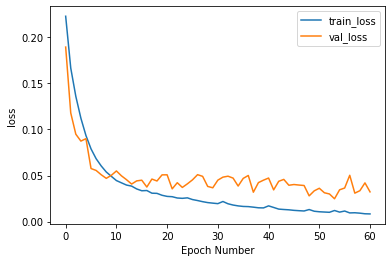

In [11]:

model_name_id = 'model_best_' + paramsTrain.model_type + '_' + \
    paramsTrain.seq_date + '_' + paramsTrain.dataset + '_' + \
    paramsTrain.model_name + '.h5'


trainTest.setData()
trainTest.setModel()

trainTest.preprocess(model_name_id) # move into if
if paramsTrain.train == True:
  trainTest.train()
else:
  trainTest.modelLoad(model_name_id)



## Evaluate


In [12]:
trainTest.evaluate()

[@debug] dataset.py:1067 in loadMask()
         str(self.paramsTrain.path): '../../../dataset/dataset/cv_data'
[@debug] dataset.py:1069 in loadMask()- self.mask.shape: (8492, 7995)
[@debug] dataset.py:891 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] params_reconstruct.py:42 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] params_reconstruct.py:42 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] mosaic.py:44 in __init__()- paramsTrain.seq_date: 'jun'


[@debug] dataset = cv
[@debug] paramsTrain.model_type = unet


[@debug] mosaic.py:70 in create()- data.class_n: 10
[@debug] mosaic.py:71 in create()
         np.unique(data.full_label_test): array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8)
         len(np.unique(data.full_label_test)): 10
[@debug] mosaic.py:72 in create()
         np.unique(data.full_label_train): array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
         len(np.unique(data.full_label_train)): 10
[@debug] mosaic.py:122 in create()
         prediction_mosaic.shape: (8492, 7995)
         mask_pad.shape: (8492, 7995)
         data.full_label_test.shape: (8492, 7995)
[@debug] mosaic.py:123 in create()
         np.unique(data.full_label_test, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                               array([65000618,   730790,  1199149,    25986,    88785,   312353,
                                                                        83385,   362633,      308,    89533]))
[@debug] mo

Entering newLabel2labelTranslate
[@debug] np.unique(label,return_counts=True) = (array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([64191828,  1804462,    81865,   175107,   452645,   252106,
         695401,     3996,   236130]))
[@debug] np.unique(label)[-1] = 8
[@debug] np.unique(label,return_counts=True) = (array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([64191828,  1804462,    81865,   175107,   452645,   252106,
         695401,     3996,   236130]))
[@debug] np.unique(label,return_counts=True) = (array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([64191828,  1804462,    81865,   175107,   452645,   252106,
         695401,     3996,   236130]))
new_labels2labels filename <_io.BufferedReader name='new_labels2labels_cv_20160613_S1.pkl'>
[@debug] new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}
[@debug] classes = [1 2 3 4 5 6 7 8 9]
1
Translated 2
2
Translated 3
3
Translated 4
4
Translated 6
5
Translated 7
6
Translated 8
7
Translate

[@debug] mosaic.py:157 in create()
         np.unique(prediction_mosaic, return_counts=True): (array([ 2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                            array([64191828,  1804462,    81865,   175107,   452645,   252106,
                                                                    695401,     3996,   236130]))
[@debug] mosaic.py:160 in create()
         data.full_label_test.shape: (8492, 7995)
[@debug] mosaic.py:161 in create()
         np.unique(data.full_label_test, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                               array([65000618,   730790,  1199149,    25986,    88785,   312353,
                                                                        83385,   362633,      308,    89533]))
[@debug] mosaic.py:163 in create()
         np.unique(label_mosaic, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11]

[@debug] important_classes_idx = [1, 2, 3, 5, 6, 7, 8, 9, 10]
[@debug] np.unique(label,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(predictions,return_counts=True) = (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8), array([64191828,  1804462,    81865,   175107,   452645,   252106,
         695401,     3996,   236130]))
[@debug] np.unique(label_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(prediction_mosaic,return_counts=True) = (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8), array([64191828,  1804462,    81865,   175107,   452645,   252106,
         695401,     3996,   236130]))
[@debug] label_mo

[@debug] mosaic.py:189 in create()
         data.mask.shape: (8492, 7995)
         mask_pad.shape: (8492, 7995)
         label_mosaic.shape: (8492, 7995)
         prediction_mosaic.shape: (8492, 7995)
[@debug] mosaic.py:202 in save_prediction_label_mosaic_Nto1()
         np.unique(mask, return_counts=True): (array([0, 1, 2], dtype=uint8), array([61778564,  3222054,  2892922]))


[@debug] np.unique(label_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(prediction_mosaic,return_counts=True) = (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8), array([64191828,  1804462,    81865,   175107,   452645,   252106,
         695401,     3996,   236130]))
everything outside mask is 255


[@debug] mosaic.py:213 in save_prediction_label_mosaic_Nto1()
         np.unique(label_mosaic,return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                      array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                              362633,      308,    89533, 65000618]))
[@debug] mosaic.py:214 in save_prediction_label_mosaic_Nto1()
         np.unique(prediction_mosaic,return_counts=True): (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8),
                                                           array([64191828,  1804462,    81865,   175107,   452645,   252106,
                                                                   695401,     3996,   236130]))


(11, 3)
Gray uint8
Adding color...
RGB uint8 (8492, 7995, 3)
[@debug] custom_colormap = [[255 146  36]
 [255 255   0]
 [164 164 164]
 [255  62  62]
 [  0   0   0]
 [172  89 255]
 [  0 166  83]
 [ 40 255  40]
 [187 122  83]
 [217  64 238]
 [ 45 150 255]]
Assigning color...
RGB uint8 (8492, 7995, 3)
Saving the resulting images...
[@debug] save_folder = results/spatial_results/cv/unet/jun


[@debug] mosaic.py:276 in save_prediction_label_mosaic_Nto1()
         prediction_savename: PosixPath('results/spatial_results/cv/unet/jun/prediction_t_jun_unet_closedset_closed_set_overl0_test.png')


saving...
no file to remove
[@debug] ret = True


[@debug] mosaic.py:286 in save_prediction_label_mosaic_Nto1()
         save_folder / ("label_t_"+paramsTrain.seq_date+"_"+paramsTrain.model_type+"_"+name_id+".png"): PosixPath('results/spatial_results/cv/unet/jun/label_t_jun_unet_closed_set.png')


[@debug] ret = True
[@debug] ret = True
======================= METRICS GET


[@debug] metrics.py:31 in get()
         prediction.shape: (8492, 7995)
         label.shape: (8492, 7995)
[@debug] metrics.py:32 in get()
         np.unique(prediction, return_counts=True): (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8),
                                                     array([64191828,  1804462,    81865,   175107,   452645,   252106,
                                                             695401,     3996,   236130]))
[@debug] metrics.py:33 in get()
         np.unique(label, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                        362633,      308,    89533, 65000618]))
[@debug] metrics.py:34 in get()
         len(np.unique(label, return_counts=True)): 2
[@debug] metrics.py:39 in get()- class_n: 9


[@debug] prediction.shape,debug,2 = (8492, 7995)
[@debug] label.shape,debug,2 = (8492, 7995)
[@debug] prediction.shape = (8492, 7995)
[@debug] prediction.shape = (67893540,)


[@debug] metrics.py:67 in get()
         np.unique(prediction, return_counts=True): (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8),
                                                     array([64191828,  1804462,    81865,   175107,   452645,   252106,
                                                             695401,     3996,   236130]))
[@debug] metrics.py:68 in get()
         np.unique(label, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                        362633,      308,    89533, 65000618]))


Metric label unique+1,count [ 2  3  4  6  7  8  9 10 11] [ 730790 1199149   25986   88785  312353   83385  362633     308   89533]
Metric prediction unique+1,count [ 2  3  4  6  7  8  9 10 11] [ 677774 1183369   46955  103276  220138   97304  442504     269  121333]
[@debug] metrics_test = {'f1_score': 0.693843339294618, 'f1_score_weighted': 0.7625025326285819, 'f1_score_noavg': array([0.67244229, 0.90952429, 0.42338328, 0.71134692, 0.72402726,
       0.88828872, 0.51967057, 0.71750433, 0.6784024 ]), 'overall_acc': 0.7586713364549753, 'confusion_matrix': array([[ 473589,   55722,    8038,   10550,    5772,     818,  173725,
              2,    2574],
       [  54283, 1083479,    7375,    5203,    1787,    1711,   42879,
             13,    2419],
       [   4875,    1502,   15441,      32,     337,       0,    3799,
              0,       0],
       [   6279,    3607,     962,   68311,    2944,     615,    3870,
              1,    2196],
       [  27046,    4296,   13850,   13527,  19